# CIS545 Final Project

The goal of our project is to identify important factors and trends that impact the entertainment industry.

In this project, we explored various entertainment data sources (ex: IMDB) to identify what drives revenue, ratings, and other metrics for actors, genres, and various other categories.

## Executive Summary

The movie industry contributes significantly to the global entertainment market and understanding these factors can have significant implications for stakeholders in the industry. Movies have a significant impact on society from shaping public opinion to reflecting societal norms and values.

This project can highlight the most important factors that affect the financial performance and ratings for movies.

### Setup and Install Dependencies

Our project requires a number of libraries to manipulate the data and visualize it. We've included most of them below as well as in the cells they are first required to run.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

In [3]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
import string
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Various fields in our datasets did not exactly match but consistency was required for combining data and for analysis. We wrote a custom fuzzy match function to handle input and match it across dataframes

In [4]:
!pip install fuzzywuzzy
!pip install python-Levenshtein
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
def match_name(movie_name, dataset, movie_name_column, threshold=80):
    match = process.extractOne(movie_name, dataset[movie_name_column], score_cutoff=threshold)
    if match:
        matched_movie, _, matched_index = match
        matched_row = dataset[dataset[movie_name_column] == matched_movie]
        return matched_row
    return pd.DataFrame()


        

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


## Importing Raw Files for Datasets

You don't need to run the cells in this section so they are commented out.

In [5]:
# Many files were in .gz format and required gunzip to unpack the files

#import gzip
#from sh import gunzip

In [6]:
# Explore movielens and upload some datasets

# !wget https://files.grouplens.org/datasets/movielens/ml-25m.zip
# !unzip ml-25m.zip -d ./


In [7]:
# IMDB Names
# !wget https://datasets.imdbws.com/name.basics.tsv.gz
# !gunzip name.basics.tsv.gz -d ./

In [8]:
# This cell can be deleted
# IMDB Title AKAs
# !wget https://datasets.imdbws.com/title.akas.tsv.gz
# !gunzip title.akas.tsv.gz -d ./


In [9]:
# IMDB Title Basics
#!wget https://datasets.imdbws.com/title.basics.tsv.gz
#!gunzip title.basics.tsv.gz -d ./

In [10]:
# IMDB Title Crew
# !wget https://datasets.imdbws.com/title.crew.tsv.gz
# !gunzip title.crew.tsv.gz -d ./

In [11]:
# IMDB Title Principals
# !wget https://datasets.imdbws.com/title.principals.tsv.gz
# !gunzip title.principals.tsv.gz -d ./

In [12]:
# IMDB Title Ratings
# !wget https://datasets.imdbws.com/title.ratings.tsv.gz
# !gunzip title.ratings.tsv.gz -d ./

### Loading the MovieLens Data

The MovieLens "Genome" data contains a variety of csv files which have information about various user generated and algorithmically generated tags associated with movies, movie metadata, and ratings.

We'll later combine these with data from other sources such as ticket sales to figure out what sorts of insights we can figure out about users, actors/actresses, and movies.

In [13]:
# Each movie in the MovieLens database has a movieId and a tagId representing a specific tag
ml_genome_scores_df = pd.read_csv('/work/ml-25m/genome-scores.csv')
print(ml_genome_scores_df.head())

   movieId  tagId  relevance
0        1      1    0.02875
1        1      2    0.02375
2        1      3    0.06250
3        1      4    0.07575
4        1      5    0.14075


In [14]:
# tagIds are mapped to their actual string value (ex: "thought-provoking") in genome-tags.csv
ml_genome_tags_df = pd.read_csv('/work/ml-25m/genome-tags.csv')
print(ml_genome_tags_df.head())

   tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s


MovieLens datasets have their own movieId identifiers. Links.csv provides us a mapping between MovieLens' movieIds and the more popular identifier imdbId for movie titles hosted on the industry standard IMDB platform.

In [15]:
ml_links_df = pd.read_csv('/work/ml-25m/links.csv')
print(ml_links_df.head())
#ml_links_df.dtypes

   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0


The movie titles in the MovieLens datasets are formatted differently from those in IMDB datasets. Most notably, MovieLens movie titles combine the actual movie title with the year in which it was released in the format "Movie Name (Year)". For example, Toy Story (1995).

We use a regular expression to replace the years with empty spaces then strip any leading and trailing whitespace to get a consistent title. While there are some inconsistencies with the IMDB data due to special characters or additional words like "The", most of the movie titles exactly match.

In [16]:
ml_movies_df = pd.read_csv('/work/ml-25m/movies.csv')
ml_movies_df.head()

# Use a regular expression to get rid of the (year)
ml_movies_df['title'] = ml_movies_df['title'].replace(r'\(\d{4}\)', '', regex=True)
ml_movies_df['title'] = ml_movies_df['title'].str.strip()

# ml_genre_link_df = ml_links_df.merge(ml_movies_df, how='inner', left_on='movieId',right_on='movieId')
# ml_genre_link_df.head()

In [17]:
# MovieLens movies have user provided ratings for movies, each uniquely identified by a timestamp
ml_ratings_df = pd.read_csv('/work/ml-25m/ratings.csv')
print(ml_ratings_df.head())

   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510


In [18]:
# Users also tag movies, each selection uniquely identified by a timestamp
ml_tags_df = pd.read_csv('/work/ml-25m/tags.csv')
print(ml_tags_df.head())

   userId  movieId               tag   timestamp
0       3      260           classic  1439472355
1       3      260            sci-fi  1439472256
2       4     1732       dark comedy  1573943598
3       4     1732    great dialogue  1573943604
4       4     7569  so bad it's good  1573943455


## Analysis

Various datasets took a while to pre-process due to the file sizes and limited RAM on our machine. In order to make our queries more efficient and reduce duplicative computations, in some cases we pre-processed the data then overwrote the source files so that subsequent cell blocks would only need to load the processed file into a dataframe. For example, we dropped unused columns, dropped null values, or combined tables and output a new file.

## Correlation between Production Budget and Movie Ratings and the Number of Tickets Sold

In this section we analyzed whether movies with high production budgets correlate to high movie ratings from IMDB data and high number of tickets sold. 

##  Data Cleaning: Preparing for Analysis

In [19]:
# # Run: Filter and overwrite MovieData.csv file to reduce RAM usage in subsequent runs
# movie_data_df = pd.read_csv('/work/MovieData.csv')
# movie_budget_df = movie_data_df.drop(['movie_odid', 'source', 'production_method', 'sequel', 'running_time', 'domestic_box_office', 'international_box_office', 'rating', 'creative_type'], axis = 1)
# movie_budget_df = movie_budget_df.dropna()
# movie_budget_df.to_csv('work/MovieData.csv', index=True)


In [20]:
# # Run: Filter and overwrite TopGrossingMovies1980-2022.csv file to reduce RAM usage in subsequent runs

# """ 
# TopGrossingMovies1980-2022.csv contains data on top domestic movie in US and Canada from 2000 to 2022
# """ 
# top_grossing_movies_df = pd.read_csv("/work/TopGrossingMovies1980-2022.csv")
# top_grossing_movies_df = top_grossing_movies_df.drop(['distributor', 'gross'], axis = 1)

# # filterTopGrossingMovies1980-2022.csv. in release date, just get the year
# top_grossing_movies_df['release_year'] = top_grossing_movies_df['release_date'].str.extract(r'(\d{4})')
# top_grossing_movies_df = top_grossing_movies_df.drop(['release_date'], axis = 1)
# top_grossing_movies_df = top_grossing_movies_df.dropna()

# top_grossing_movies_df.to_csv('work/TopGrossingMovies1980-2022.csv', index=True)

In [21]:
# # Run: Filter and overwrite IMDBb_Data_finals.csv file to reduce RAM usage in subsequent runs

# #IMDBb_Data_finals.csv contains Title,Director, Starts, IMDb-rating, Category, Year etc
# movie_rating_df = pd.read_csv("/work/IMDb_Data_final.csv")
# movie_rating_df = movie_rating_df.drop(['Category', 'Director', 'Stars', 'Duration', 'Censor-board-rating'], axis = 1)
# #rename from Title to movie_name
# movie_rating_df = movie_rating_df.rename(columns = {'Title': 'movie_name'})
# movie_rating_df = movie_rating_df.dropna()

# movie_rating_df.to_csv('work/IMDb_Data_final.csv', index=True)

MovieData.csv contains data on movie title, production year(2006-2018), production budget greater than equal to $10 milion, box office (both domestic and international), rating, genre, etc. 

ActorsDomesticBoxOffice.csv contains data on 600 actors and actresses' domestic box office

TopGrossingMovies1980-2022.csv contains data on top domestic movie in US and Canada from 2000 to 2022. 


GenresMarketShare1995-2023.csv contains genre based movie breakdown for the top 25 movies for each genre (Action, Drama, etc) from 1995-2023.

In [22]:

movie_data_df = pd.read_csv('/work/MovieData.csv')
movie_budget_df = movie_data_df.drop(['movie_odid', 'source', 'production_method', 'sequel', 'running_time', 'domestic_box_office', 'international_box_office', 'rating', 'creative_type'], axis = 1)
movie_budget_df = movie_budget_df.dropna()


actors_domestic_box_office_df = pd.read_csv("/work/ActorsDomesticBoxOffice.csv")

top_grossing_movies_df = pd.read_csv("/work/TopGrossingMovies1980-2022.csv")
top_grossing_movies_df = top_grossing_movies_df.drop(['distributor', 'gross'], axis = 1)

# filterTopGrossingMovies1980-2022.csv. in release date, just get the year
top_grossing_movies_df['release_year'] = top_grossing_movies_df['release_date'].str.extract(r'(\d{4})')
top_grossing_movies_df = top_grossing_movies_df.drop(['release_date'], axis = 1)
top_grossing_movies_df = top_grossing_movies_df.dropna()

# Reconcile movie names with imdb database
# print(top_grossing_movies_df.head())
# top_grossing_movies_df["movie_name"] = top_grossing_movies_df["movie_name"].apply(lambda x: get_matching_imdb_field(x, imdb_title_basic_df, 'primaryTitle'))
# print(top_grossing_movies_df.head())


genres_market_share_df = pd.read_csv("/work/GenresMarketShare1995-2023.csv")

#IMDBb_Data_finals.csv contains Title,Director, Starts, IMDb-rating, Category, Year etc
movie_rating_df = pd.read_csv("/work/IMDb_Data_final.csv")
movie_rating_df = movie_rating_df.drop(['Category', 'Director', 'Stars', 'Duration', 'Censor-board-rating'], axis = 1)
#rename from Title to movie_name
movie_rating_df = movie_rating_df.rename(columns = {'Title': 'movie_name'})
movie_rating_df = movie_rating_df.dropna()


Throughout our project, we have used head() to see and analyze our datasets to see if our queries were done correctly instead of outputting the entire dataframe. Printing out the entire dataframe can be overwhelming and difficult to read, especially if the dataset is large. The head() function was a very efficient and quick ways to  preview the first few rows of the dataset, gave us an idea of the data's structure and the types of values contained within it.

In [23]:
print(top_grossing_movies_df.head())
print(top_grossing_movies_df.dtypes)

                     movie_name      genre num_tickets_sold release_year
0  Star Wars Ep. V: The Empire…  Adventure       67,417,790         1980
1                    Stir Crazy     Comedy       37,657,992         1980
2             Kramer vs. Kramer      Drama       36,796,566         1979
3                     Airplane!     Comedy       31,023,620         1980
4         Any Which Way You Can     Comedy       26,277,823         1980
movie_name          object
genre               object
num_tickets_sold    object
release_year        object
dtype: object


### Analysis and Result 

The analysis is based on three different datasets - movie_budget_df, movie_rating_df, and top_grossing_movies_df. The goal was to determine whether production budget correlates with higher movie rating and number of tickets sold.

The analysis found that a high production budget does not necessarily correlate with a higher-rated movie. For instance, Avatar, which had a production budget of 425 million USD, received an IMDb rating of 7.8, while The Dark Knight, which had a production budget of $185 million, received the highest rating of 9.0. Therefore, the data suggests that a high production budget is not the only factor that contributes to a higher-rated movie.

However, the analysis found that a high production budget correlates with a higher number of tickets sold. Avatar, with a budget of $425 million, sold 101,404,550 tickets. Therefore, the data suggests that a high production budget can contribute to the commercial success of a movie.

In conclusion, while a high production budget does not necessarily guarantee a higher-rated movie, it can contribute to the commercial success of a movie by attracting a larger audience. Therefore, filmmakers should consider the balance between production budget and artistic merit when making movies.

In [24]:

# merge the movie budget and rating DataFrames on movie name
production_budget_df = pd.merge(movie_budget_df, movie_rating_df, on='movie_name')

 
highest_production_budged_df = production_budget_df.sort_values(by=['production_budget'], ascending=False)
print("Movies with the Highest Production Budget: ")
print("\n")
print(highest_production_budged_df.head(1))

highest_movie_rating_df = production_budget_df.sort_values(by=['IMDb-Rating'], ascending=False)
print("Movies with the Highest Rating: ")
print(highest_movie_rating_df.head(1))


#removed , and changed datatype to int for num_tickets_sold column
top_grossing_movies_df['num_tickets_sold'] = top_grossing_movies_df['num_tickets_sold'].str.replace(',', '').astype(int)


#merge num_tickets_sold_by_movie and top_grossing_movies_df on movie_name
movie_data_with_num_tickets = pd.merge(production_budget_df, top_grossing_movies_df, on='movie_name')

#used agg() to sum num_of_tickets and agerage IMDb-Rating because there were duplicate movie sets.  
movie_data_with_num_tickets = movie_data_with_num_tickets.groupby('movie_name').agg({'production_budget': 'mean', 'num_tickets_sold': 'sum', 'IMDb-Rating': 'mean'}).reset_index()
movie_data_with_num_tickets = movie_data_with_num_tickets.sort_values(by=['num_tickets_sold'], ascending=False)
print("Number of Movie Tickets Sold Based on Production Budget: ")
print(movie_data_with_num_tickets.head(1))




Movies with the Highest Production Budget: 


   movie_name  production_year  production_budget   genre  IMDb-Rating  \
58     Avatar             2009          425000000  Action          7.8   

    ReleaseYear  
58         2009  
Movies with the Highest Rating: 
         movie_name  production_year  production_budget   genre  IMDb-Rating  \
41  The Dark Knight             2008          185000000  Action          9.0   

    ReleaseYear  
41         2008  
Number of Movie Tickets Sold Based on Production Budget: 
   movie_name  production_budget  num_tickets_sold  IMDb-Rating
10     Avatar          425000000         101404550          7.8


In [25]:
#print(len(top_grossing_movies_df))
#print(top_grossing_movies_df.head())
# print(len(movie_data_with_num_tickets))
# print(movie_data_with_num_tickets.head())
#print(production_budget_df.head())
#print(len(production_budget_df))

## Exploring the Relationship Between Actors/Actresses and High Movie Ticket Sales: A Correlation Analysis 

In this section, we analyzed whether certain actors and or actresses correlates with a high movie ticket sales. 

##  Data Cleaning: Preparing for Analysis

The main challenges I had in this analysis is to match movie titles in different dataframes. We used fuzzy string matching algorithm initially however, this matching method took a long time to get result. What we did was to create a function remove_punctuation() to remove punctuation converted all alphabets to lower case anved all space.

In [26]:

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator).lower()
    #remove all space
    text = text.replace(' ', '')

    return text

actor_df = pd.read_csv("/work/ActorsDomesticBoxOffice.csv")
title_and_tickets_df = pd.read_csv("/work/TopGrossingMovies1980-2022.csv")
title_stars_df = pd.read_csv("/work/IMDb_Data_final.csv")

name_avg_revenue_df = actor_df.drop(['domestic_box_office', 'movies_num'], axis = 1)
name_avg_revenue_df = name_avg_revenue_df.rename(columns = {'average': 'average_domestic_office'})
print(name_avg_revenue_df.head())

name_avg_revenue_df = name_avg_revenue_df.drop_duplicates()

name_avg_revenue_df['actor_name'] = name_avg_revenue_df['actor_name'].apply(remove_punctuation)


movie_num_tickets_df = title_and_tickets_df[['movie_name', 'num_tickets_sold']]
movie_num_tickets_df['movie_name'] = movie_num_tickets_df['movie_name'].astype(str)
movie_num_tickets_df['movie_name'] = movie_num_tickets_df['movie_name'].apply(remove_punctuation)
movie_num_tickets_df = movie_num_tickets_df.dropna()

movie_num_tickets_df['num_tickets_sold'] = movie_num_tickets_df['num_tickets_sold'].str.replace(',', '').astype(int)

movie_num_tickets_df = movie_num_tickets_df.drop_duplicates()

top_actors_df = title_stars_df[['Title', 'Stars']]
top_actors_df = top_actors_df.rename(columns = {'Stars': 'main_actors'})
top_actors_df['Title'] = top_actors_df['Title'].astype(str)
top_actors_df['Title'] = top_actors_df['Title'].apply(remove_punctuation)
top_actors_df = top_actors_df.drop_duplicates()


merged_df = movie_num_tickets_df.merge(top_actors_df, left_on='movie_name', right_on='Title')
grouped_df = merged_df.groupby('movie_name').agg({'num_tickets_sold': 'sum', 'main_actors': ', '.join}).reset_index()
grouped_df = grouped_df.dropna()
final_output_df = grouped_df[['movie_name', 'num_tickets_sold', 'main_actors']]
final_output_df['main_actors'] = final_output_df['main_actors'].str.replace(',', '', 1)
final_output_df['main_actors'] = final_output_df['main_actors'].str.lower()


           actor_name average_domestic_office
0   Samuel L. Jackson          $89,351,628.00
1  Robert Downey, Jr.         $124,412,871.00
2  Scarlett Johansson         $160,272,778.00
3           Tom Hanks          $93,265,907.00
4          Tom Cruise         $108,827,768.00
/tmp/ipykernel_207/2679263024.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_num_tickets_df['movie_name'] = movie_num_tickets_df['movie_name'].astype(str)
/tmp/ipykernel_207/2679263024.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

##  Who had the Highest Number of Ticket Sales?

The analysis is based on the 'final_output_df' dataset, which contains information about movie ticket sales and main actors. The objective is to determine which main actors lead to high ticket sales.

The analysis found that certain actors do lead to high ticket sales. The top three main actors are Tom Hanks, Robert Downey Jr, and Chris Evans, with 395 million, 343 million, and 316 million tickets sold, respectively. The analysis suggests that these actors have a strong fan base and can draw a large audience to the movies they star in.

Overall, the analysis provides insight into the relationship between main actors and movie ticket sales. By identifying which main actors lead to high ticket sales, filmmakers can make more informed decisions when casting actors for their movies.

In [27]:
#helper function to format the final output of number of tickets. 
def format_num_tickets(num_tickets):
    return '{:,}'.format(num_tickets)

top5_movie_tickets_df = final_output_df.sort_values(by='num_tickets_sold', ascending=False)

new_rows = []
_ = top5_movie_tickets_df.apply(lambda row: [new_rows.append([row['movie_name'], row['num_tickets_sold'], actor.strip()]) for actor in row['main_actors'].split(',')], axis=1)
new_df = pd.DataFrame(new_rows, columns=['movie_name', 'num_tickets_sold', 'main_actors'])
new_df = new_df.dropna()
new_df = new_df.drop_duplicates()
new_df = new_df[new_df['main_actors'].str.len() > 0]
new_df = new_df[~new_df['main_actors'].str.contains(' ')]
new_df['main_actors'] = new_df['main_actors'].apply(lambda x: re.sub(r'[^a-zA-Z]+', '', str(x)))

new_df = new_df.groupby('main_actors')['num_tickets_sold'].sum().reset_index()
new_df = new_df.sort_values(by='num_tickets_sold', ascending=False)
new_df = new_df[new_df['main_actors'].notnull()]
new_df =new_df[new_df['num_tickets_sold'].notna() & (new_df['main_actors'] != '')]

new_df = new_df.reset_index(drop=True)
new_df['num_tickets_sold'] = new_df['num_tickets_sold'].apply(format_num_tickets)

print(new_df.head(10))


        main_actors num_tickets_sold
0          tomhanks      395,015,602
1    robertdowneyjr      343,068,400
2        chrisevans      316,647,595
3  leonardodicaprio      285,786,065
4       markruffalo      230,876,733
5    chrishemsworth      208,373,680
6         mattdamon      189,221,474
7   sigourneyweaver      185,145,784
8        kathybates      177,405,801
9    whoopigoldberg      175,702,855


## Writer with Most Awards 

In this section, we analyzed writers who won the most awards after 1980 using Golden Globe and Oscars datasets.

##  Data Cleaning: Preparing for Analysis

Cleaned data for Golden Globe datasets and the Oscar. 

In [28]:
# # Run: Filter and overwrite golden_globe_awards.csv file to reduce RAM usage in subsequent runs
# golden_globe_awards_df = pd.read_csv("/work/golden_globe_awards.csv") 

# golden_globe_awards_df = golden_globe_awards_df.drop(['ceremony'], axis = 1)


# golden_globe_awards_df = golden_globe_awards_df[
#     (golden_globe_awards_df['year_film'] >= 1980) &
#     (golden_globe_awards_df['category'].str.startswith("Best Screenplay")) &
#     (golden_globe_awards_df['win'] == True)
# ]

# # golden_globe_awards_df.to_csv("/work/golden_globe_awards.csv", index=True)


In [29]:
# # Run: Filter and overwrite the_oscar_award.csv file to reduce RAM usage in subsequent runs
# oscars_df = pd.read_csv("/work/the_oscar_award.csv")
# oscars_df = oscars_df[["category", "name", "winner", "film", "year_film"]]
# oscars_df = oscars_df[(oscars_df['winner'] == True) & (oscars_df['year_film'] >=1980) & oscars_df["category"].str.startswith(("ACTOR","ACTRESS"))]
# oscars_df = oscars_df.groupby("name").agg({"film": lambda x: x.tolist(), "winner": "count"})
# oscars_df = oscars_df.rename(columns={"winner": "count"})
# oscars_df = oscars_df.reset_index()
# oscars_df = oscars_df.sort_values("count", ascending=False)

# # oscars_df.to_csv("/work/the_oscar_award.csv", index=True)


##  Which Writer Won the Most Award?

Based on the analysis provided, Quentin Tarantino is the writer who won the most awards after 1980, with a total of 3 awards. Tarantino won two Academy Awards for Best Original Screenplay for Pulp Fiction (1994) and Django Unchained (2012), and one Golden Globe Award for Best Screenplay for Once Upon a Time...in Hollywood (2019).

The analysis shows that both the Academy Awards and the Golden Globe Awards were considered in determining which writer won the most awards. The analysis was limited to awards given after 1980 and specifically looked at the Best Screenplay and Writing categories for the Golden Globe Awards and Academy Awards respectively.

It is important to note that while this analysis provides insight into which writer won the most awards after 1980, it may not be representative of the overall success or influence of a writer's body of work. Additionally, the analysis is limited to two major award shows and does not consider other important awards or recognition given to writers in the industry.


In [30]:

golden_globe_awards_df = pd.read_csv("/work/golden_globe_awards.csv") 

golden_globe_awards_df = golden_globe_awards_df.drop(['ceremony'], axis = 1)


golden_globe_awards_df = golden_globe_awards_df[
    (golden_globe_awards_df['year_film'] >= 1980) &
    (golden_globe_awards_df['category'].str.startswith("Best Screenplay")) &
    (golden_globe_awards_df['win'] == True)
]

#groupby name and create a column named count and count the number of awards given to a specific name
golden_globe_awards_df = golden_globe_awards_df.groupby("nominee").agg({"film": lambda x: x.tolist(), "year_film": "count"})
golden_globe_awards_df = golden_globe_awards_df.rename(columns={"year_film": "count"})
golden_globe_awards_df = golden_globe_awards_df.reset_index()
golden_globe_awards_df = golden_globe_awards_df.sort_values("count", ascending=False)


oscars_df = pd.read_csv("/work/the_oscar_award.csv")
oscars_df = oscars_df[["category", "name", "winner", "film", "year_film"]]
oscars_df = oscars_df[(oscars_df['winner'] == True) & (oscars_df['year_film'] >=1980) & oscars_df["category"].str.startswith("WRITING")]
oscars_df = oscars_df.groupby("name").agg({"film": lambda x: x.tolist(), "winner": "count"})
oscars_df = oscars_df.rename(columns={"winner": "count"})
oscars_df = oscars_df.reset_index()
oscars_df = oscars_df.sort_values("count", ascending=False)


#combine golden_globe_awards_df and oscars_df 

combined_df = pd.concat([golden_globe_awards_df, oscars_df])
combined_df = combined_df[['nominee', 'film', 'count']]
combined_df = combined_df.head(1)
print("A writer who won the most awards after 1980")
print(combined_df[['nominee']])
print("Wrote the following: ")
def print_list(lst):
    for item in lst:
        print(item)

combined_df['film'].apply(print_list)




A writer who won the most awards after 1980
              nominee
25  Quentin Tarantino
Wrote the following: 
Pulp Fiction
Django Unchained
Once Upon a Time...in Hollywood


25    None
Name: film, dtype: object

In [31]:
# Explore oscars and upload some datasets
oscars_df = pd.read_csv('/work/the_oscar_award.csv')

###  Retrieve title basic

The IMDB dataset had useful metadata associated with movies. We needed to have a source of truth for fields like the movie title where it was in some cases inconsistent across data sources. Because these tables were large, we needed to read the rows in as chunks and then filter. To minimize load times in future runs, we overwrote the raw files so we'd only have to compute once. This allowed us to conserve RAM on our machine and time re-running cells.

In [32]:
# To reduce the overhead on compute, subsequent cells will simply call
#pd.read_csv('/work/title.basics.tsv', sep = '\t')

# #Retrieve all data points whose start dates > 1980
#chunks = pd.read_csv('/work/title.basics.tsv', sep = '\t',chunksize=10**5)
#filtered_dataframes = []
#for chunk in chunks:
   #chunk = chunk[(chunk['titleType'] == 'movie') & (chunk['startYear'] != '\\N')]
   #chunk = chunk.drop(columns=['isAdult','endYear'])
   #filtered_chunk =  chunk[chunk['startYear'].astype(int) >= 1980]
   #filtered_dataframes.append(filtered_chunk)
#imdb_title_basic_df = pd.concat(filtered_dataframes)

In [33]:
# This cell was run once to filter title.basics.tsv from the logic above
# # Run: Filter and overwrite /work/title.basics.tsv file to reduce RAM usage in subsequent runs
#imdb_title_basic_df.to_csv('/work/title.basics.tsv', sep = '\t', index=True)
#print(imdb_title_basic_df.head())

In [34]:
# This cell was run once to filter title.basics.tsv to drop originalTitle and titleType
# imdb_title_basic_df = pd.read_csv('/work/title.basics.tsv', sep = '\t')
# #print(imdb_title_basic_df.head())
# imdb_title_basic_df.drop(columns=['originalTitle', 'titleType'], axis=1, inplace=True)
# print(imdb_title_basic_df.head())
# imdb_title_basic_df.to_csv('/work/title.basics.tsv', sep = '\t', index=True)

In [35]:
imdb_title_basic_df = pd.read_csv('/work/title.basics.tsv', sep = '\t')

### Retrieve name.basic

The names of actors and actresses across our datasets were not always standardized and in some cases contained misspellings. Since the IMDB data seemed mostly correct, we decided to use it as the source of truth. Loading the IMDB dataset was initially challenging as the files exceeded the memory on our machines, causing it to crash. We were able to resolve these issues by loading chunks and filtering out unused fields and columns then restricting the date range of our datasets.

In [36]:
# To reduce the overhead on compute, subsequent cells will simply call
# pd.read_csv('/work/name.basics.tsv', sep = '\t')

# chunks = pd.read_csv('/work/name.basics.tsv', sep = '\t',chunksize=10**5)
# filtered_dataframes = []
# for chunk in chunks:
#   chunk = chunk[chunk['birthYear'] != '\\N']
#   chunk = chunk.drop(columns=['deathYear'])
#   filtered_chunk =  chunk[chunk['birthYear'].astype(int) >= 1930]
#   filtered_dataframes.append(filtered_chunk)
# imdb_name_basic_df = pd.concat(filtered_dataframes)

In [37]:
# This cell was run once to filter title.basics.tsv from the logic above
# Run: Filter and overwrite work/title.principals.tsv file to reduce RAM usage in subsequent runs
# imdb_name_basic_df.to_csv('/work/name.basics.tsv', sep = '\t', index=True)

In [38]:
imdb_name_basic_df = pd.read_csv('/work/name.basics.tsv', sep = '\t')

In [39]:
imdb_name_basic_df.head()

Unnamed: 0     nconst        primaryName  birthYear  \
0           2  nm0000003    Brigitte Bardot       1934   
1           3  nm0000004       John Belushi       1949   
2          14  nm0000015         James Dean       1931   
3          28  nm0000029  Margaux Hemingway       1954   
4          34  nm0000035       James Horner       1953   

                      primaryProfession  \
0   actress,soundtrack,music_department   
1               actor,soundtrack,writer   
2                   actor,miscellaneous   
3                 actress,miscellaneous   
4  music_department,soundtrack,composer   

                            knownForTitles  
0  tt0057345,tt0049189,tt0054452,tt0056404  
1  tt0080455,tt0078723,tt0077975,tt0072562  
2  tt0049261,tt0048545,tt0039123,tt0048028  
3  tt0074802,tt0077800,tt0102122,tt0110138  
4  tt0499549,tt0177971,tt0120746,tt0120338

The IMDB dataset also contained a mapping of actors and actresses to the movies they participated in. These fields were nested and contained various types of ids, so we combined this with the data for names and titles to get a dataframe containing the actors and the movie titles. We used the resulting table to filter datasets and join datasets, particularly for the MovieLens tags analysis. Since the MovieLens dataset also contained IMDB movie ids, we were able to use these to join the datasets too.

In [40]:
# Get the list of movies an actor is associated with, one row per actor/movie
# Ran once to get actor 'primaryName' and their imdbId for movies they starred in

# # Actors and imdb movie id
# people_and_imdb_movie_id_df = imdb_name_basic_df[["primaryName", "knownForTitles"]].copy()
# print(people_and_imdb_movie_id_df.head())

# # Unnest movies so there is one row per name and movie
# people_and_imdb_movie_id_df["knownForTitles"] = people_and_imdb_movie_id_df['knownForTitles'].str.split(',')
# people_and_imdb_movie_id_df = people_and_imdb_movie_id_df.explode('knownForTitles')
# people_and_imdb_movie_id_df.rename(columns = {'knownForTitles': 'imdbId'}, inplace=True)
# people_and_imdb_movie_id_df["imdbIdString"] = people_and_imdb_movie_id_df["imdbId"]
# people_and_imdb_movie_id_df["imdbId"] = people_and_imdb_movie_id_df["imdbId"].str.replace("tt","")
# # Get rid of leading 0's in id
# people_and_imdb_movie_id_df['imdbId'] = people_and_imdb_movie_id_df['imdbId'].apply(lambda x: x.lstrip('0'))
# people_and_imdb_movie_id_df["imdbId"] = pd.to_numeric(people_and_imdb_movie_id_df['imdbId'], errors='coerce')
# people_and_imdb_movie_id_df['imdbId'].fillna(value=np.nan, inplace=True)
# people_and_imdb_movie_id_df['imdbId'] = people_and_imdb_movie_id_df['imdbId'].apply(lambda x: '0' if pd.isna(x) else x)
# people_and_imdb_movie_id_df['imdbId'] = people_and_imdb_movie_id_df['imdbId'].astype(int)

# people_and_imdb_movie_id_df.to_csv('work/IMDB_People_and_Movies.csv', index=True)

# # Example with Harrison Ford
# print(people_and_imdb_movie_id_df[people_and_imdb_movie_id_df["primaryName"] == "Harrison Ford"].head(20))

We'll need to run this cell for the MovieLens tags data analysis later on.

In [41]:
people_and_imdb_movie_id_df = pd.read_csv('/work/IMDB_People_and_Movies.csv')

In [42]:
print(people_and_imdb_movie_id_df.head())

   Unnamed: 0      primaryName  imdbId imdbIdString
0           0  Brigitte Bardot   57345    tt0057345
1           0  Brigitte Bardot   49189    tt0049189
2           0  Brigitte Bardot   54452    tt0054452
3           0  Brigitte Bardot   56404    tt0056404
4           1     John Belushi   80455    tt0080455


### Retrieve principal cast and crew members

In [43]:
# To reduce the overhead on compute, subsequent cells will simply call
# pd.read_csv('work/title.principals.tsv', sep = '\t')

# chunks = pd.read_csv('/work/title.principals.tsv', sep = '\t',chunksize=10**5)
# filtered_dataframes = []
# for chunk in chunks:
#   chunk = chunk[chunk['job'] != '\\N']
#   chunk = chunk.drop(columns=['ordering'])
#   chunk = chunk[chunk['nconst'].isin(imdb_name_basic_df['nconst'])]
# #  filtered_chunk =  chunk[chunk['birthYear'].astype(int) >= 1930]
#   filtered_dataframes.append(chunk)
# imdb_title_principle_df = pd.concat(filtered_dataframes)

In [44]:
# This cell was run once to filter title.basics.tsv from the logic above
# Run: Filter and overwrite /work/title.principals.tsv file to reduce RAM usage in subsequent runs
# imdb_title_principle_df.to_csv('/work/title.principals.tsv', sep = '\t', index=True)


In [45]:
imdb_title_principle_df = pd.read_csv('/work/title.principals.tsv', sep = '\t')

In [46]:
print(imdb_title_principle_df.head(100))

    Unnamed: 0     tconst     nconst  category         job characters
0        53872  tt0008381  nm8432614  composer    composer         \N
1        67792  tt0010146  nm1084708  producer    producer         \N
2        75447  tt0011144  nm1084708  producer    producer         \N
3        76113  tt0011223  nm0004592  producer    producer         \N
4        76424  tt0011263  nm0004592  producer    producer         \N
..         ...        ...        ...       ...         ...        ...
95      405741  tt0049281  nm0778633    writer  screenplay         \N
96      405796  tt0049287  nm0341458    writer  screenplay         \N
97      405884  tt0049297  nm2170574    writer        idea         \N
98      407511  tt0049477  nm0928611    writer       story         \N
99      407700  tt0049498  nm0778633    writer  screenplay         \N

[100 rows x 6 columns]


In [47]:

'''
due to how manual scraping splits values into different columns, this clean-up here is \
to collapse everything back together. Place the cleaned dataframes into a dictionary to \
be used for future computations. 
'''
import os
import pandas as pd
imdb_ratings_df = pd.read_csv('/work/title.ratings.tsv',sep='\t')
folder_path = '/work/actors/'
all_files = os.listdir(folder_path)
actors_dict = {}
for csv_file in all_files:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path)
    df['movieTitle'] = df['movieTitle'].fillna(df['wrong_column'])
    df = df.drop('wrong_column', axis=1)
    df = df.rename(columns={'date': 'year'})
    df['year'] = df['year'].str.extract(', (\d{4})')
    df = df.dropna(subset=['year','domesticBoxOffice'])
    df['year'] = df['year'].astype(int)
    df['domesticBoxOffice'] = df['domesticBoxOffice'].str.replace('[$,]', '',regex=True).astype(int)
    df = df.sort_values('year', ascending=True)
    # use the csv file name without the extension as the key
    actor_name = os.path.splitext(csv_file)[0]
    actors_dict[actor_name] = df

# robert_df = pd.read_csv('work/robert_downey.csv',sep=',')
# '''
# Due to web scraping issues, the movie title is split between differently columns.\
# Collapsing the two columns into one
# '''
# df['movieTitle'] = df['movieTitle'].fillna(df['wrong_column'])
# df = df.drop('wrong_column', axis=1)
# df = df.rename(columns={'date': 'year'})
# df['year'] = df['year'].str.extract(', (\d{4})')
# df = df.dropna(subset=['year','worldwideBoxOffice'])
# df['year'] = df['year'].astype(int)
# df = df.sort_values('year', ascending=True)
# df.head(30)

# Time series analysis

### Box office revenue over time

The charts depicting box office revenue fail to account for the effects of annual inflation, thereby rendering them insufficient in gauging the true financial success of movies. Among the top 30 actors and actresses, the zenith of their movie revenue has often been observed in the latter half of the 2000s, particularly in the case of high-budget films such as those belonging to the Marvel Cinematic Universe. While certain actors display a consistent baseline revenue with limited variance, others exhibit significantly more volatility.

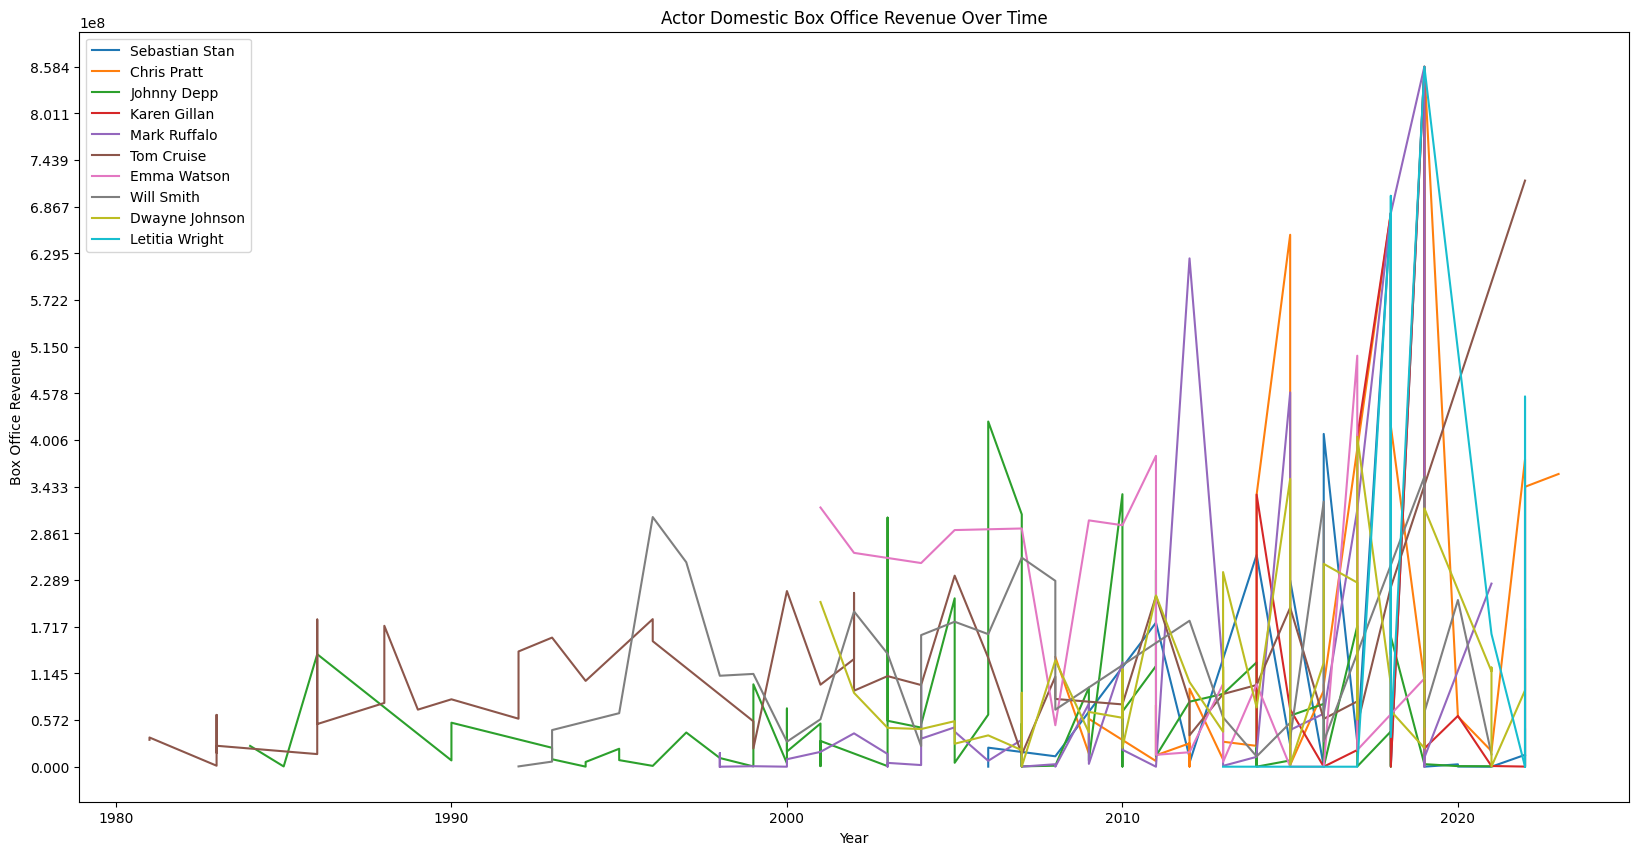

In [48]:
'''
collapse columns back together after web scraping and save the dataframes into a dict
'''
first_10_actors = dict(list(actors_dict.items())[:10])
plt.figure(figsize=(20,10))

for actor, data in first_10_actors.items():
    actor = actor.replace('_',' ')
    plt.plot(data['year'], data['domesticBoxOffice'], label=actor)
    # sns.lineplot(data=data, x='year', y='domesticBoxOffice', label=actor,fillstyle='none')

min_value = min([min(data['domesticBoxOffice']) for data in first_10_actors.values()])
max_value = max([max(data['domesticBoxOffice']) for data in first_10_actors.values()])
tick_interval = (max_value - min_value) // 15
yticks = np.arange(min_value, max_value, tick_interval)
plt.yticks(yticks)
plt.xlabel('Year')
plt.ylabel('Box Office Revenue')
plt.title('Actor Domestic Box Office Revenue Over Time')
plt.legend()
plt.show()

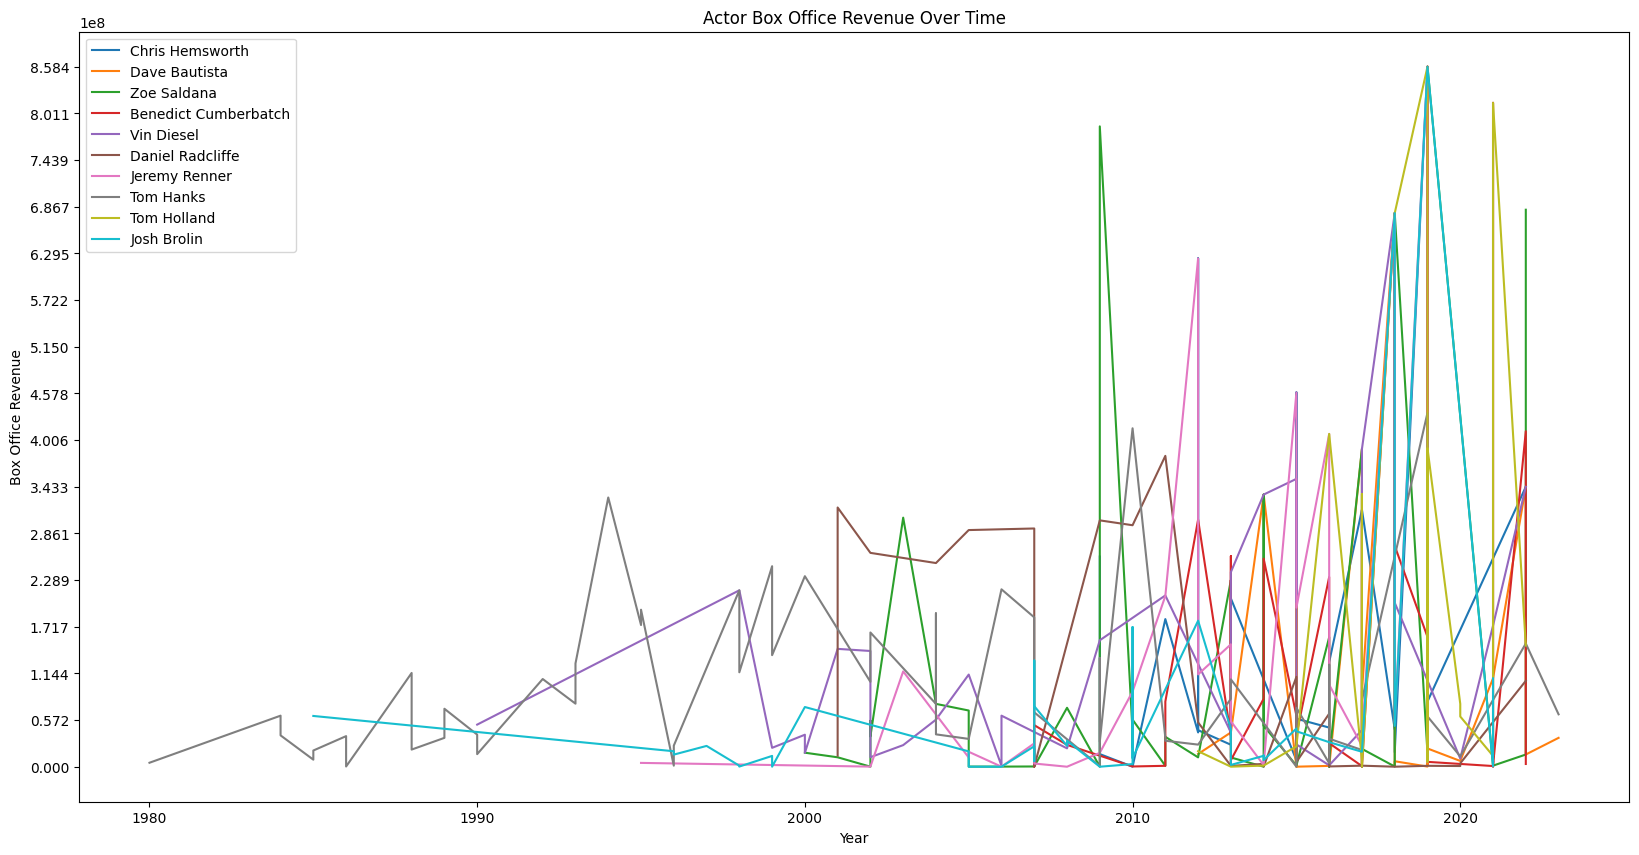

In [49]:
second_10_actors = dict(list(actors_dict.items())[10:20])
plt.figure(figsize=(20,10))

for actor, data in second_10_actors.items():
    actor = actor.replace('_',' ')
    plt.plot(data['year'], data['domesticBoxOffice'], label=actor)
    # sns.lineplot(data=data, x='year', y='domesticBoxOffice', label=actor,fillstyle='none')


min_value = min([min(data['domesticBoxOffice']) for data in second_10_actors.values()])
max_value = max([max(data['domesticBoxOffice']) for data in second_10_actors.values()])
tick_interval = (max_value - min_value) // 15
yticks = np.arange(min_value, max_value, tick_interval)
plt.yticks(yticks)
plt.xlabel('Year')
plt.ylabel('Box Office Revenue')
plt.title('Actor Box Office Revenue Over Time')
plt.legend()
plt.show()

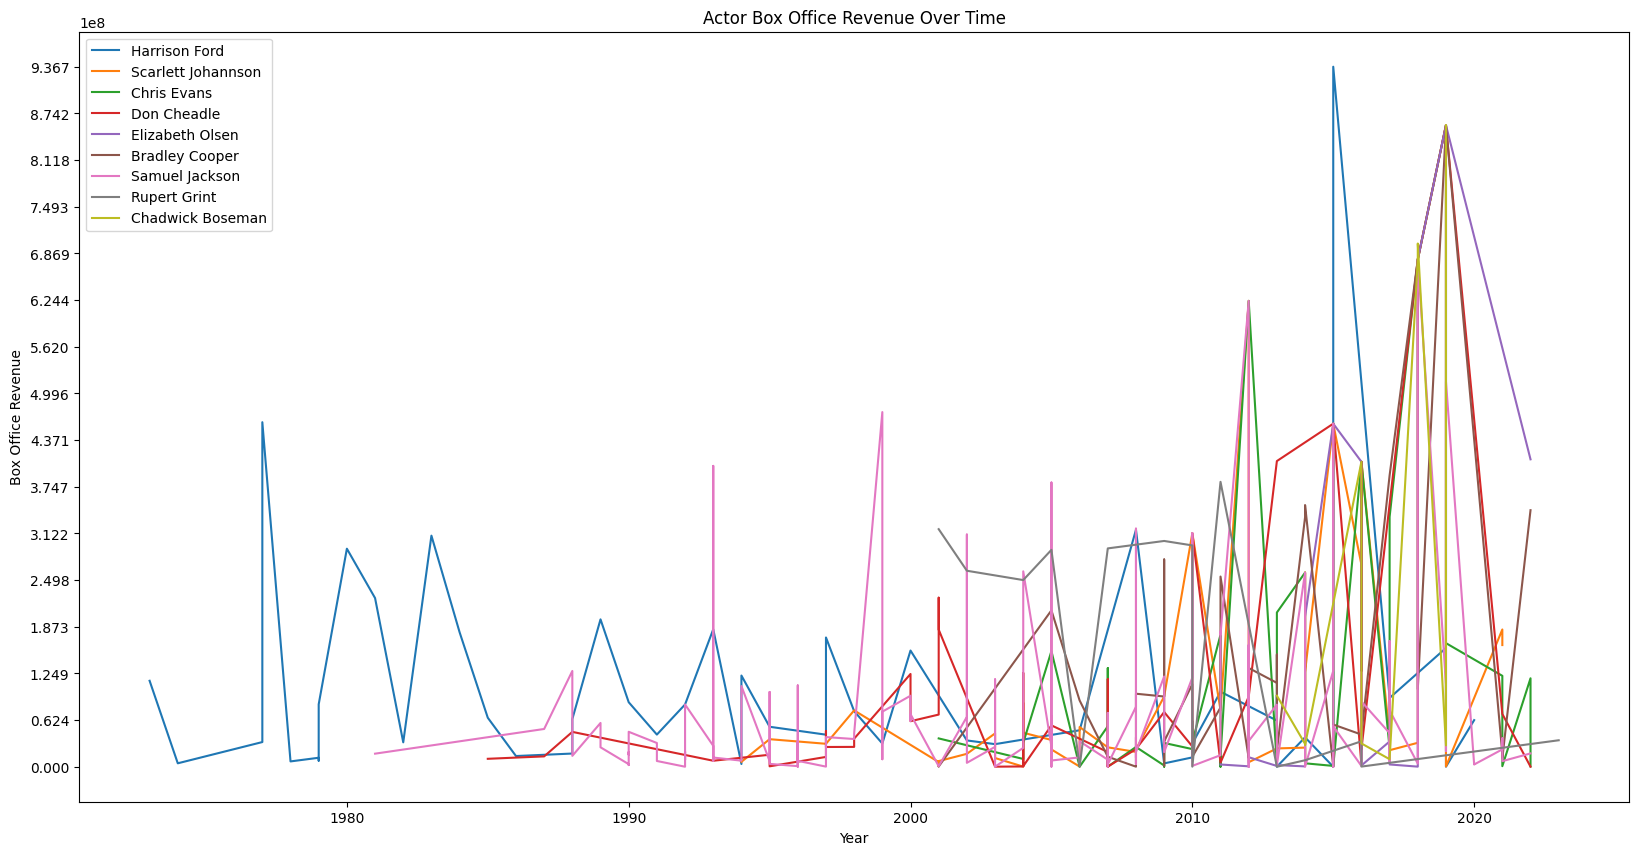

In [50]:
third_10_actors = dict(list(actors_dict.items())[20:30])
plt.figure(figsize=(20,10))

for actor, data in third_10_actors.items():
    actor = actor.replace('_',' ')
    plt.plot(data['year'], data['domesticBoxOffice'], label=actor)
    # sns.lineplot(data=data, x='year', y='domesticBoxOffice', label=actor,fillstyle='none')

min_value = min([min(data['domesticBoxOffice']) for data in third_10_actors.values()])
max_value = max([max(data['domesticBoxOffice']) for data in third_10_actors.values()])
tick_interval = (max_value - min_value) // 15
yticks = np.arange(min_value, max_value, tick_interval)
plt.yticks(yticks)
plt.xlabel('Year')
plt.ylabel('Box Office Revenue')
plt.title('Actor Box Office Revenue Over Time')
plt.legend()
plt.show()

In [51]:
actor_ratings_dict = {}
for actor, df in actors_dict.items():
    merged_df = df.merge(imdb_title_basic_df, left_on=['year','movieTitle'],right_on=['startYear','primaryTitle'],how='inner')
    merged_df = merged_df[['year','tconst']]
    merged_df = merged_df.merge(imdb_ratings_df,left_on='tconst',right_on='tconst',how='inner')
    actor_ratings_dict[actor] = merged_df


### Actor film ratings over time

Notable actors such as Scarlett Johansson, Samuel L. Jackson, Dave Bautista, and Johnny Depp exhibit a discernible pattern of significant fluctuations in their film ratings, characterized by pronounced highs and lows. In contrast, actors like Tom Cruise and Vin Diesel demonstrate a tendency to gravitate towards a more narrow range of ratings.  On the whole, it appears that the majority of actor reception traverses a broad spectrum, avoiding prolonged periods of disapproval or unanimous acclaim.

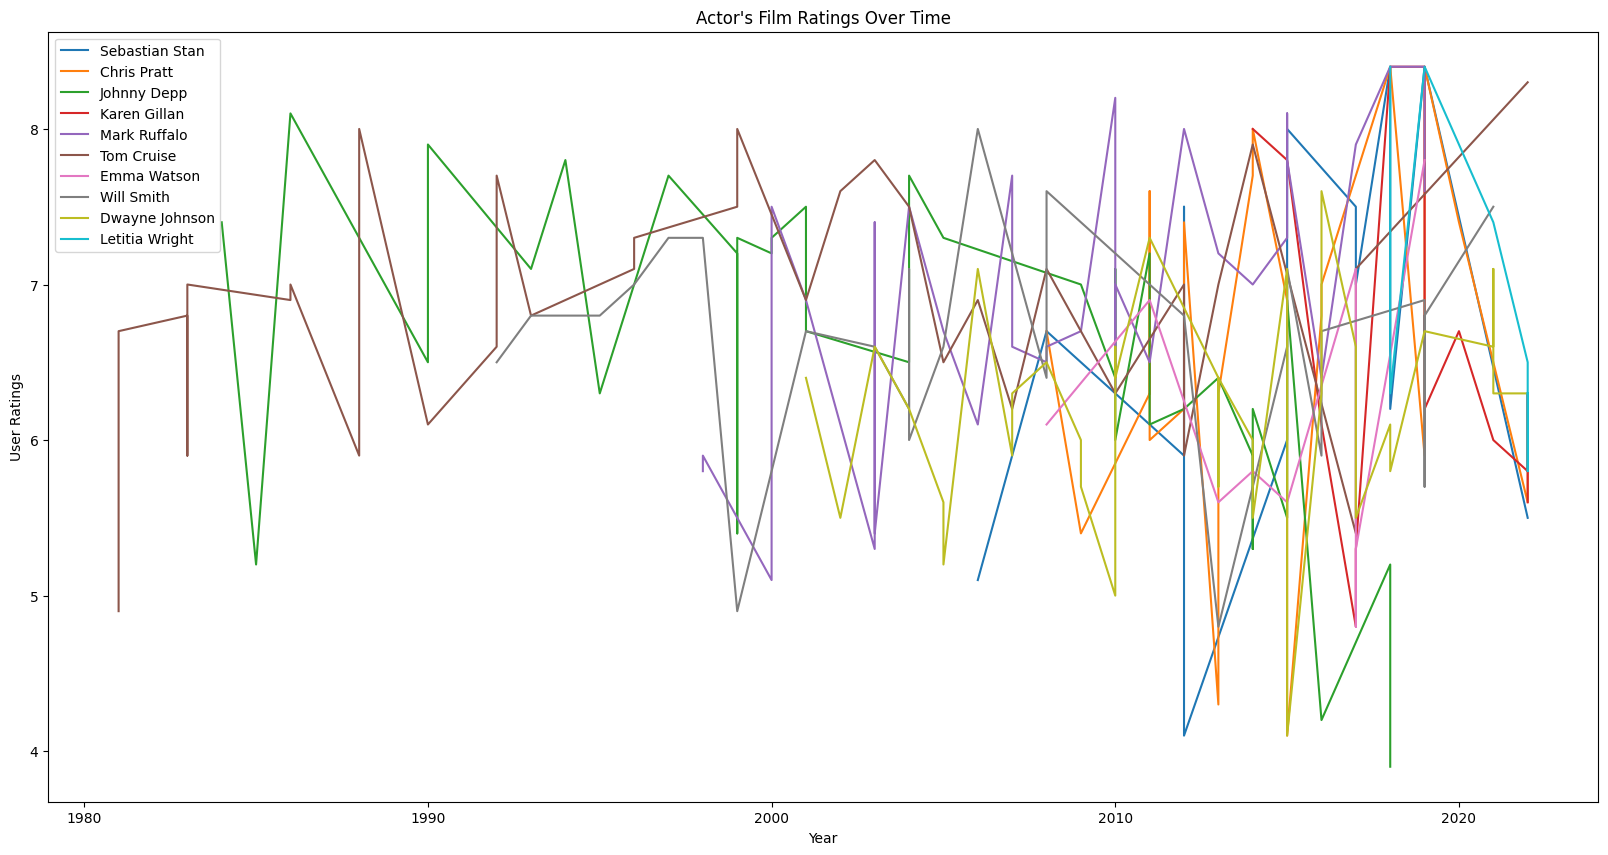

In [52]:
first_6_ratings = dict(list(actor_ratings_dict.items())[:10])
plt.figure(figsize=(20,10))

for actor, data in first_6_ratings.items():
    actor = actor.replace('_',' ')
    plt.plot(data['year'], data['averageRating'], label=actor)
    # sns.lineplot(data=data, x='year', y='averageRating', label=actor)

plt.xlabel('Year')
plt.ylabel('User Ratings')
plt.title('Actor\'s Film Ratings Over Time')
plt.legend()
plt.show()

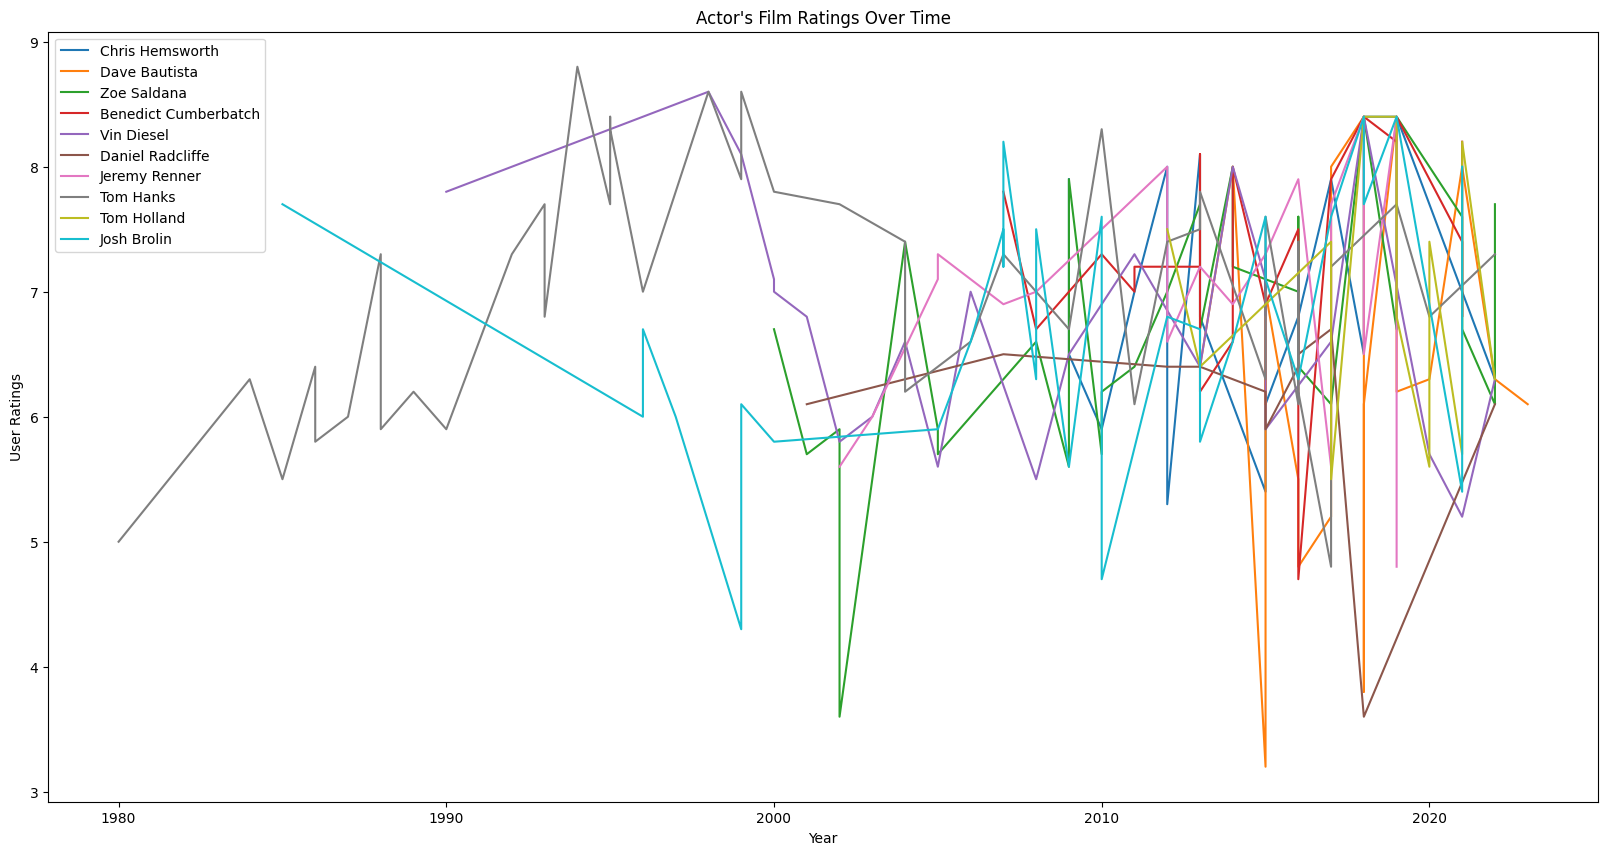

In [53]:
second_10_ratings = dict(list(actor_ratings_dict.items())[10:20])
plt.figure(figsize=(20,10))

for actor, data in second_10_ratings.items():
    actor = actor.replace('_',' ')
    plt.plot(data['year'], data['averageRating'], label=actor)
    # sns.lineplot(data=data, x='year', y='averageRating', label=actor)

plt.xlabel('Year')
plt.ylabel('User Ratings')
plt.title('Actor\'s Film Ratings Over Time')
plt.legend()
plt.show()

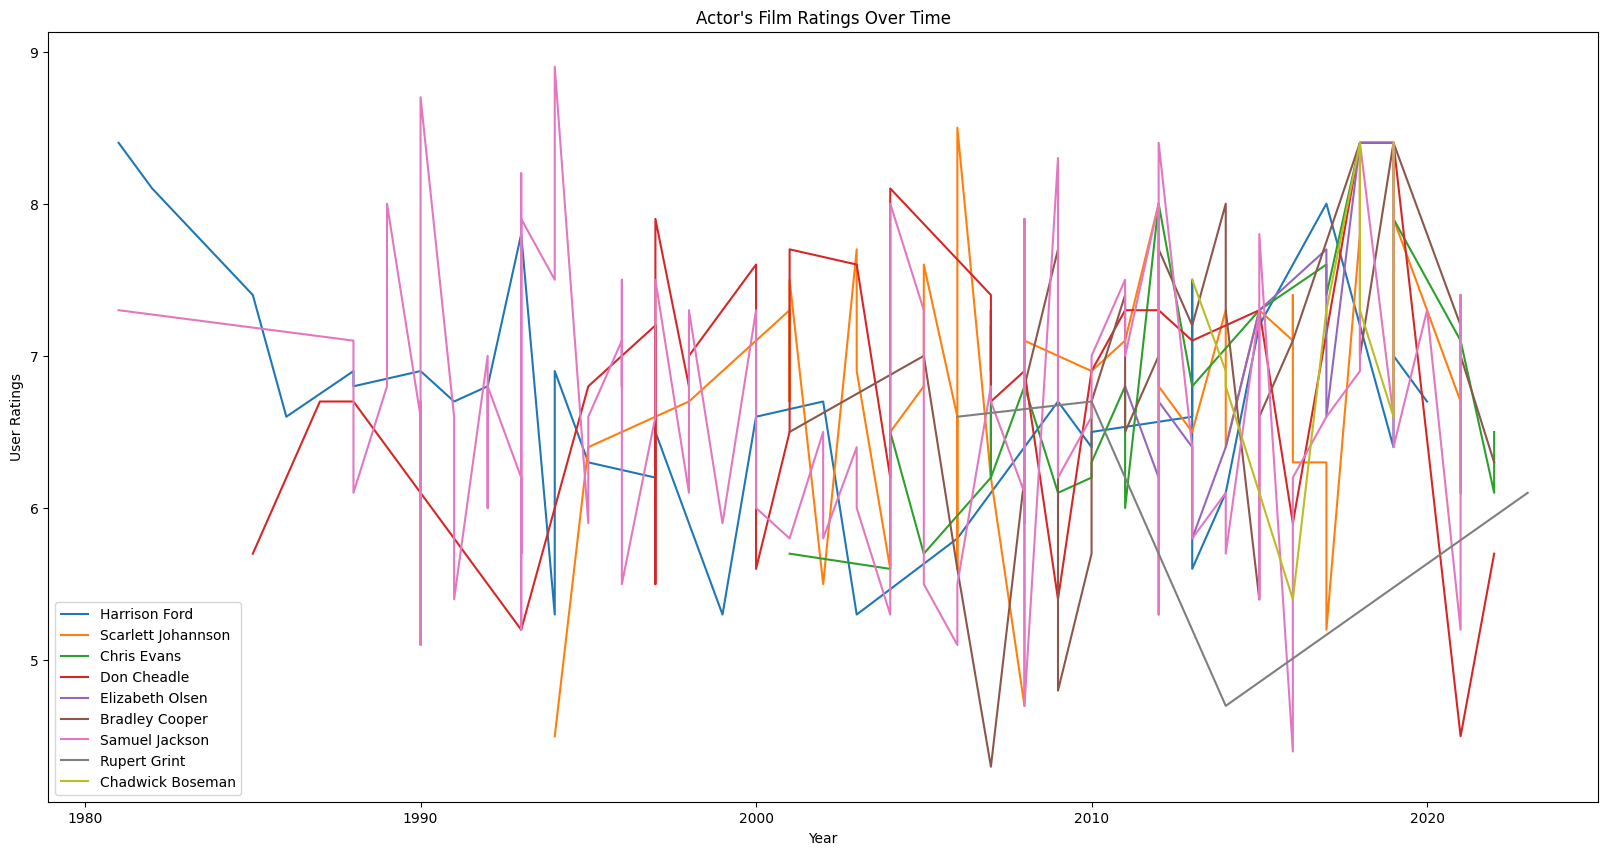

In [54]:
third_10_ratings = dict(list(actor_ratings_dict.items())[20:30])
plt.figure(figsize=(20,10))

for actor, data in third_10_ratings.items():
    actor = actor.replace('_',' ')
    plt.plot(data['year'], data['averageRating'], label=actor)
    # sns.lineplot(data=data, x='year', y='averageRating', label=actor)

plt.xlabel('Year')
plt.ylabel('User Ratings')
plt.title('Actor\'s Film Ratings Over Time')
plt.legend()
plt.show()

### Age of actors who won awards

In [55]:
oscars_df = pd.read_csv("/work/the_oscar_award.csv")
oscars_df = oscars_df[["category", "name", "winner", "film", "year_film","year_ceremony"]]
oscars_df = oscars_df[(oscars_df['winner'] == True) & (oscars_df['year_film'] >=1980) & oscars_df["category"].str.startswith(('ACTOR','ACTRESS'))]
oscars_df = oscars_df.groupby('name')['year_ceremony'].min().reset_index()
oscars_df.head()

# matched = [match_name(actor,imdb_name_basic_df,'primaryName') for actor in oscars_df['name']]
actors_oscars = oscars_df.merge(imdb_name_basic_df, left_on='name',right_on='primaryName',how='inner')
actors_oscars=actors_oscars[['name','year_ceremony','birthYear']]
actors_oscars['age_received_oscars'] = actors_oscars['year_ceremony'] - actors_oscars['birthYear']
actors_oscars = actors_oscars[['name','age_received_oscars']]
actors_oscars.head(300)

name  age_received_oscars
0       Adrien Brody                   30
1          Al Pacino                   53
2         Alan Arkin                   73
3    Alicia Vikander                   28
4     Allison Janney                   59
..               ...                  ...
136       Will Smith                   54
137       Will Smith                   51
138       Will Smith                   49
139       Will Smith                   41
140     William Hurt                   36

[141 rows x 2 columns]

Actors on the cusp of their 30's often witness a significant uptick in their likelihood of receiving their first Oscars, with a significant amount of Oscar winners typically occurring in the mid to late 30's. However, there appears to be no discernible downtrend past the 30's as a considerable number of actors still have the opportunity to attain their Oscars well into their mid-50s. In contrast, the Golden Globe Awards seem to favor actors in their 40s. The overwhelming majority of actors attain their first awards in their 30's and 40's

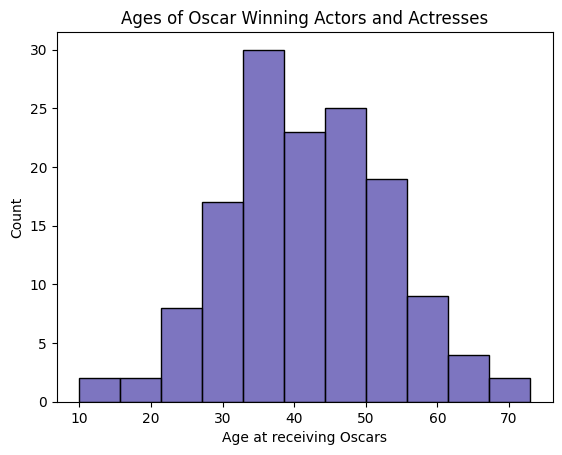

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data=actors_oscars,x="age_received_oscars",color='#5247AB')
plt.xlabel('Age at receiving Oscars')
plt.title('Ages of Oscar Winning Actors and Actresses')
plt.show()

In [57]:
import pandas as pd
golden_globe_awards_df = pd.read_csv("/work/golden_globe_awards.csv") 
golden_globe_awards_df = golden_globe_awards_df.drop(['ceremony'], axis = 1)
golden_globe_awards_df = golden_globe_awards_df[
    (golden_globe_awards_df['year_film'] >= 1980) &
    (golden_globe_awards_df['category'].str.startswith("Best Performance")) &
    (golden_globe_awards_df['win'] == True)
]
# golden_globe_awards_df = golden_globe_awards_df[['year_award','nominee']]
golden_globe_awards_df= golden_globe_awards_df.groupby('nominee')['year_award'].agg(min).reset_index()
actors_globes = golden_globe_awards_df.merge(imdb_name_basic_df,left_on='nominee',right_on='primaryName',how='inner')
actors_globes['age_received_globe'] = actors_globes['year_award']-actors_globes['birthYear']
actors_globes = actors_globes[['nominee','age_received_globe']]

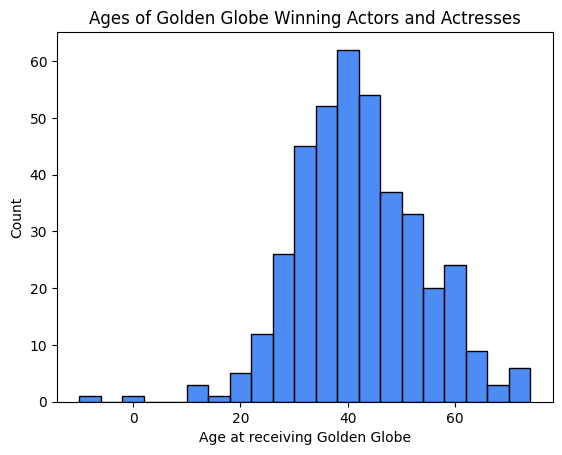

In [58]:
sns.histplot(data=actors_globes,x="age_received_globe",color='#1166F2')
plt.xlabel('Age at receiving Golden Globe')
plt.title('Ages of Golden Globe Winning Actors and Actresses')
plt.show()

In [59]:
actors_oscars_and_globes = actors_oscars.merge(actors_globes, left_on='name',right_on='nominee',how='inner')
actors_oscars_and_globes['min_age'] = actors_oscars_and_globes.apply(lambda row: min(row['age_received_oscars'], row['age_received_globe']), axis=1)
actors_oscars_and_globes = actors_oscars_and_globes[['name','min_age']]
actors_oscars_and_globes.head()

name  min_age
0        Al Pacino       53
1   Allison Janney       59
2   Angelina Jolie       23
3  Anjelica Huston       35
4      Anna Paquin       12

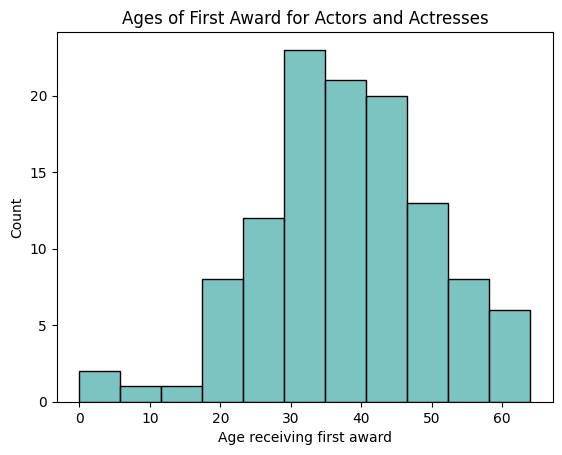

In [60]:
sns.histplot(data=actors_oscars_and_globes,x="min_age",color='#4FB0AD')
plt.xlabel('Age receiving first award')
plt.title('Ages of First Award for Actors and Actresses')
plt.show()

### Genre Trends

In [61]:
genres = imdb_title_basic_df['genres'].str.get_dummies(',')
# print(genres)
movies_and_genres = pd.concat([imdb_title_basic_df,genres],axis=1)
genre_counts = movies_and_genres.groupby('startYear')[genres.columns].sum()
genre_counts.head()

Action  Adult  Adventure  Animation  Biography  Comedy  Crime  \
startYear                                                                  
1980          448    267        171         35         57     701    232   
1981          398    311        181         43         56     694    221   
1982          428    249        176         57         52     712    233   
1983          438    313        180         52         47     682    226   
1984          408    394        168         49         64     706    249   

           Documentary  Drama  Family  ...  Reality-TV  Romance  Sci-Fi  \
startYear                              ...                                
1980               419   1503     103  ...           0      261      64   
1981               393   1486     134  ...           0      292      53   
1982               379   1532     143  ...           0      293      58   
1983               425   1597     116  ...           0      308      64   
1984               433   1590     145  ...           1      309      84   

           Short  Sport  Talk-Show  Thriller  War  Western   \N  
startYear                                                        
1980           0     23          0       156   70       17  841  
1981           0     19          2       154   78       14  785  
1982           0     25          0       166   65       18  768  
1983           0     30          0       159   92       11  782  
1984           0     23          0       177   74       11  908  

[5 rows x 28 columns]

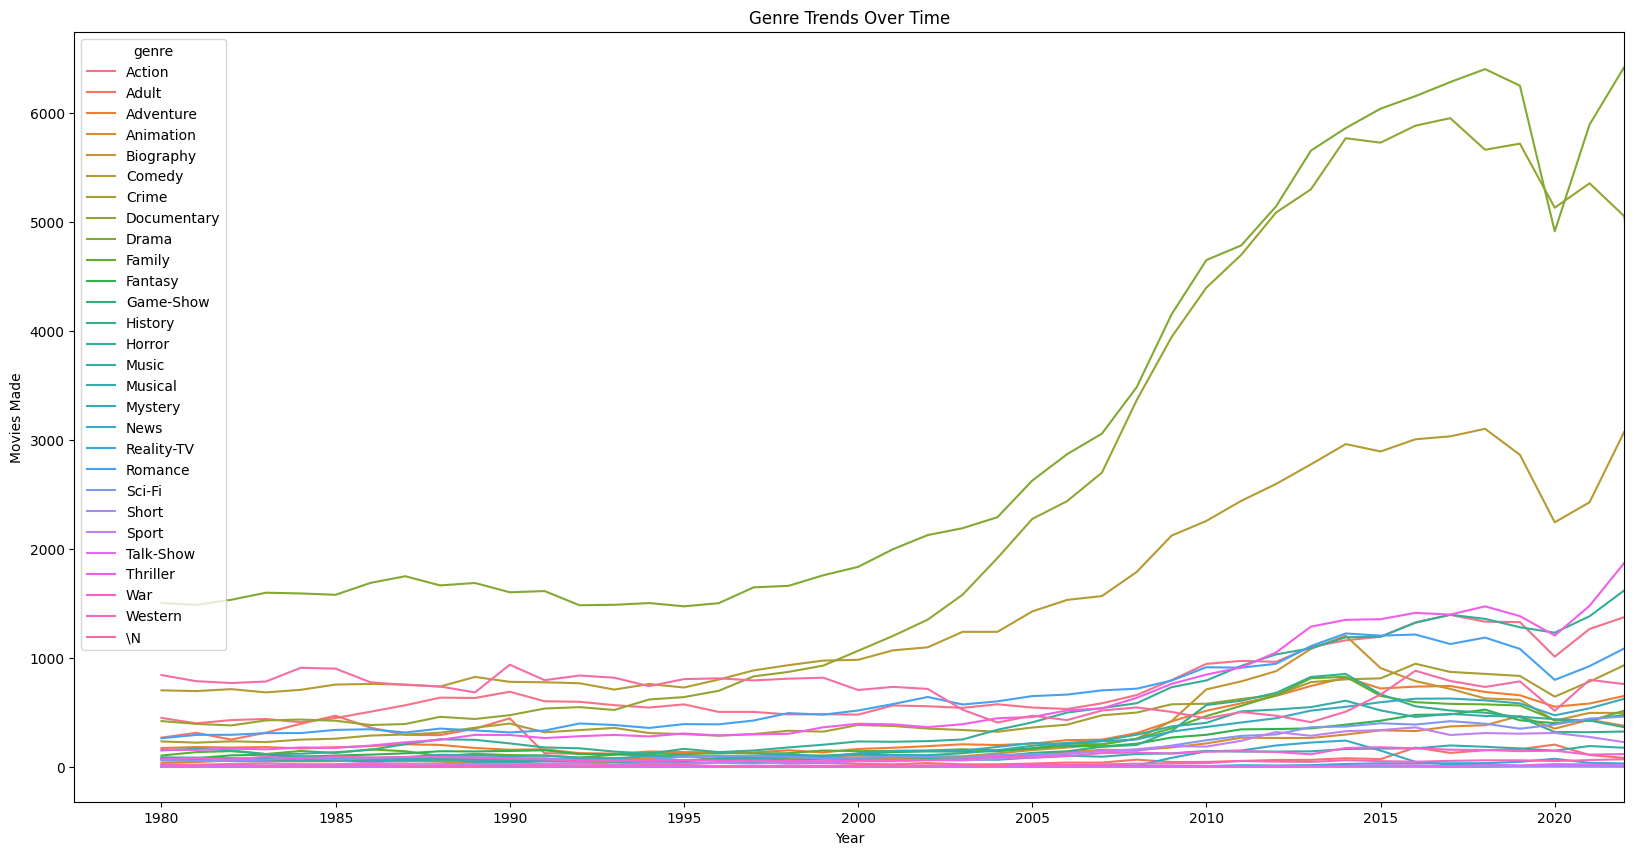

In [62]:
genre_counts_melted = genre_counts.reset_index().melt(id_vars=['startYear'], var_name='genre', value_name='count')
genre_counts_melted.head()
plt.figure(figsize=(20,10))
sns.lineplot(data=genre_counts_melted, x='startYear', y='count', hue='genre')
plt.xlim(right=2022)
plt.xlabel('Year')
plt.ylabel('Movies Made')
plt.title('Genre Trends Over Time')
plt.show()


###Analyzing with tag data

Data for top box office actors and actresses was scraped from various websites into individual CSV files. These needed to be combined into a dataframe. We'll need this later too when we analyze actors and actresses for the tags of movies they starred in.

In [63]:
# Here, we read in csv files to get year | movieTitle | domesticBoxOffice | actorName as a topActors dataframe

imdb_ratings_df = pd.read_csv('/work/title.ratings.tsv',sep='\t')
folder_path = '/work/actors'
all_files = os.listdir(folder_path)

topActors_df = pd.DataFrame()

for csv_file in all_files:
    file_path = os.path.join(folder_path, csv_file)
    tempTopActors_df = pd.read_csv(file_path)
    tempTopActors_df['movieTitle'] = tempTopActors_df['movieTitle'].fillna(tempTopActors_df['wrong_column'])
    tempTopActors_df = tempTopActors_df.drop('wrong_column', axis=1)
    tempTopActors_df = tempTopActors_df.rename(columns={'date': 'year'})
    tempTopActors_df['year'] = tempTopActors_df['year'].str.extract(', (\d{4})')
    tempTopActors_df = tempTopActors_df.dropna(subset=['year','domesticBoxOffice'])
    tempTopActors_df['year'] = tempTopActors_df['year'].astype(int)
    tempTopActors_df['actorName'] = os.path.splitext(csv_file)[0]
    tempTopActors_df['actorName'] = tempTopActors_df['actorName'].str.replace("_", " ")
    tempTopActors_df['year'] = tempTopActors_df.sort_values('year', ascending=True)
    topActors_df = pd.concat([topActors_df, tempTopActors_df])

print(topActors_df.head())
# These stats are aggregated per actor and used for the actor profiles in the tags analysis.

   year               movieTitle domesticBoxOffice       actorName
4  2022                  The 355       $14,570,455  Sebastian Stan
5  2021                   Monday           $30,932  Sebastian Stan
7  2020      Endings, Beginnings          $256,703  Sebastian Stan
8  2020    The Last Full Measure        $2,949,212  Sebastian Stan
9  2019  We Have Always Lived i…           $52,071  Sebastian Stan


Next, we prepare IMDB data for titles and ratings to be used in our modeling analysis.

In [64]:
# # Run: Filter and overwrite title.basics.tsv file to reduce RAM usage in subsequent runs
# titles_df = pd.read_csv('/work/title.basics.tsv', sep='\t', usecols=['tconst', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres'], na_values='\\N')
# titles_df = titles_df[titles_df['startYear'] >= 1980]
# titles_df = titles_df.dropna()

# titles_df.to_csv('/work/title.basics.tsv', sep='\t', index=True)


In [65]:
# # Run: Filter and overwrite work/title.ratings.tsv file to reduce RAM usage in subsequent runs
# all_ratings_df = pd.read_csv('/work/title.ratings.tsv', sep='\t', usecols=['tconst', 'averageRating', 'numVotes'], na_values='\\N')
# all_ratings_df = all_ratings_df.dropna()

# all_ratings_df.to_csv('/work/title.ratings.tsv', sep='\t', index=True)


# Modeling Analysis

In this section, we built a linear regression model and random forest model. We used a linear regression model to predict the IMDb rating of a movie based on factors such as its budget, genre, runtime, and the number of votes it has received on IMDb. Additionally, we built a random forest model to predict the box office performance of a movie based on its production budget, domestic box office, the number of cast, number of genres, and release year.

## Model Analysis #1: Linear Regression Model

### Data Collection and Preparation

The following code reads movie data from two TSV files, filters and merges them, and then aggregates the results and writes them to a new CSV file. Additionally, it reads a separate CSV file, filters it by production year, selects specific columns, and writes the resulting data to another CSV file. To improve performance and efficiency, the code creates separate CSV files for the aggregated movie data and the filtered production budget data. 

In [66]:

titles1_df = pd.read_csv('/work/title.basics.tsv', sep='\t', usecols=['tconst', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres'], na_values='\\N')
titles1_df = titles1_df[titles1_df['startYear'] >= 1980]
titles1_df = titles1_df.dropna()

titles1_df.to_csv('/work/modeling_movie_titles.csv', index=False)

all_ratings_df = pd.read_csv('/work/title.ratings.tsv', sep='\t', usecols=['tconst', 'averageRating', 'numVotes'], na_values='\\N')
all_ratings_df = all_ratings_df.dropna()

merged_df = pd.merge(titles1_df, all_ratings_df, on='tconst')
grouped_df = merged_df.groupby(['tconst', 'primaryTitle', 'genres', 'runtimeMinutes' ]).agg({'averageRating': 'sum', 'numVotes': 'sum'}) #changed from mean to sum
grouped_df = grouped_df.reset_index()
grouped_df = grouped_df.drop("tconst", axis = 1)
grouped_df.to_csv('/work/modeling_movie_data.csv', index=False)


#use MovieData.csv and get production_budget; movie_name; production_year >=1980

prod_budget_df = movie_data_df[['movie_name', 'production_year', 'production_budget']][movie_data_df['production_year'] >= 1980]
prod_budget_df.to_csv('/work/modeling_prod_budget_data.csv', index=False)


In [67]:

modeling_movie_data_df = pd.read_csv("/work/modeling_movie_data.csv") #len = 771496
modeling_prd_budget_df = pd.read_csv("/work/modeling_prod_budget_data.csv") #len = 1936


def normalize_title(title):
    # remove all non-alphanumeric characters
    title = re.sub('[^0-9a-zA-Z]+', '', title)

    title = title.lower()
    # split into words and take the first 10
    words = title.split()[:10]
    return ' '.join(words)

modeling_movie_data_df['normalized_title'] = modeling_movie_data_df['primaryTitle'].apply(normalize_title)
modeling_prd_budget_df['normalized_title'] = modeling_prd_budget_df['movie_name'].apply(normalize_title)

# merge the data frames based on the normalized movie title
merged_df = pd.merge(modeling_movie_data_df, modeling_prd_budget_df, on='normalized_title')

merged_df = merged_df.drop(['movie_name'], axis = 1)
merged_df = merged_df.drop_duplicates(subset=['normalized_title'])

### Building Linear Regression Model 

The code applies a linear regression model to predict IMDb ratings for movies using PyTorch. Here are the steps:  
1. Encodes the categorical feature "genres" with LabelEncoder and selecting relevant features for training and testing. 
2. Standardizes the features and splits the data into training and testing sets with a test size ratio of 0.2.
3. Defined Linear Regression class that extends the nn.Module class from PyTorch. 
4. The loss function used is the mean squared error, and the optimizer is stochastic gradient descent with a learning rate of 0.01. 
5. The model is trained for 1000 epochs, and the loss function is printed every 100 epochs during training.
6. For testing, the model predicts the IMDb rating of a randomly selected movie from the test set, compares it to the actual IMDb rating, and prints both values. The output shows that the model predicts the IMDb rating of the sample movie with reasonable accuracy, as the predicted rating is close to the actual rating.

However, this analysis does not provide any information on how well the model generalizes to new data beyond the test set, or whether other regression models would perform better on this data. Therefore, further evaluation and comparison with other models would be necessary to determine the model's effectiveness and performance on different datasets.

In [68]:

#label encode genres
le = LabelEncoder()
merged_df['genres'] = le.fit_transform(merged_df['genres'])

#select features from columns
features = merged_df[['genres', 'runtimeMinutes', 'numVotes', 'production_year', 'production_budget']]
target = merged_df['averageRating']

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float).view(-1, 1)

class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

#instantiate the model
input_size = X_train.shape[1]
output_size = 1
model = LinearRegression(input_size, output_size)

#set the loss funtion and optimiz algo
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

#traning 1000 epochs 
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    #print loss of the model during trainig process
    if (epoch+1) % 100 == 0:
        print(f'Epoch: [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


#test it using sample movie sets
sample_index = 25
sample_movie = X_test[sample_index]
actual_rating = y_test[sample_index].item()

predicted_rating = model(sample_movie.unsqueeze(0)).item()
# Compare the predicted rating to the actual rating
print(f'Predicted IMDb rating: {predicted_rating:.2f}')
print(f'Actual IMDb rating: {actual_rating:.2f}')


Epoch: [100/1000], Loss: 1.4711414575576782
Epoch: [200/1000], Loss: 0.8060262799263
Epoch: [300/1000], Loss: 0.7904910445213318
Epoch: [400/1000], Loss: 0.789592981338501
Epoch: [500/1000], Loss: 0.7894754409790039
Epoch: [600/1000], Loss: 0.7894566059112549
Epoch: [700/1000], Loss: 0.7894536256790161
Epoch: [800/1000], Loss: 0.7894530892372131
Epoch: [900/1000], Loss: 0.7894530296325684
Epoch: [1000/1000], Loss: 0.7894529104232788
Predicted IMDb rating: 6.23
Actual IMDb rating: 6.40


## Modeling Analysis #2: Random Forest Model

In this section, we are using random forest model to predict the box office performance of a movie based on its production budget, domestic box office,  the number of cast, number of genres, and release year. 

### Data Collection and Preparation

In [69]:

def normalize_title(title):
    # remove all non-alphanumeric characters
    title = re.sub('[^0-9a-zA-Z]+', '', title)

    title = title.lower()
    # split into words and take the first 10
    words = title.split()[:10]
    return ' '.join(words)

df1 = pd.read_csv("/work/IMDb_Data_final.csv")
df2 = pd.read_csv("/work/MovieData.csv")

#in df1, get the stars, category, release year
data1 = df1[['Stars', 'Title', 'Category', 'ReleaseYear']] 
data1['Title'] = data1['Title'].apply(normalize_title)
#data1 = data1.rename(columns={'Title': 'movie_name'})


data2 = df2[['movie_name', 'production_budget', 'domestic_box_office']]
data2['movie_name'] = data2['movie_name'].apply(normalize_title)

merged_df = df2.merge(df1, left_on='movie_name', right_on='Title', how='inner')
merged_df = merged_df.drop_duplicates()
merged_df = merged_df.dropna()
merged_df = merged_df[['production_year', 'production_budget', 'domestic_box_office', 'Stars', 'Category']]
random_forest_df = merged_df

# Split cast and genres columns
random_forest_df['Stars'] = random_forest_df['Stars'].apply(lambda x: x.split(','))
random_forest_df['Stars'] = [len(row) for row in random_forest_df['Stars']]
random_forest_df['Category'] = random_forest_df['Category'].apply(lambda x: x.split(','))
random_forest_df['Category'] = [len(row) for row in random_forest_df['Category']]

print(random_forest_df.head())

   production_year  production_budget  domestic_box_office  Stars  Category
0             2006           13000000             13756082      4         3
1             2006           18000000             31567134      4         3
3             2006           27000000             22495466      4         3
4             2006           40000000             50866635      4         3
5             2006           40000000             53089891      4         3
/tmp/ipykernel_207/86831235.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Title'] = data1['Title'].apply(normalize_title)
/tmp/ipykernel_207/86831235.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

### Building Random Forest Model

The initial model achieved an R^2 score of 0.64, which was not as high as desired. To improve the score, I attempted to use feature engineering by creating a new feature called "budget_per_star," which divides the production budget by the number of stars in the movie. This increased the score by 0.2 to 0.66, but the improvement was not significant. Next, I tried feature scaling using StandardScaler(), but the score remained at 0.64.

Finally, I increased the number of trees, but the score remained consistent at 0.64. From this analysis, I realized that the size of our dataset was not sufficient for this model, and additional data would be required to achieve better results. To improve the model's performance, it would be necessary to crawl and fetch more data for training and testing.

### Attempt #1

In [70]:

#define features and target variable
X = random_forest_df[['production_year', 'production_budget', 'Stars', 'Category']]
y = random_forest_df['domestic_box_office']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#create a random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# R^2 score
r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2 )

Mean Squared Error: 1.1069403548682382e+16
R^2 Score: 0.6417647481376161


### Attempt #2: Feature Engineering

In [71]:


#create a new feature called "budget_per_star"
random_forest_df['budget_per_star'] = random_forest_df['production_budget'] / random_forest_df['Stars']

X = random_forest_df[['production_year', 'production_budget', 'Stars', 'Category', 'budget_per_star']]
y = random_forest_df['domestic_box_office']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)

Mean Squared Error: 1.045469541423888e+16
R^2 Score: 0.6616583334058519


### Attempt #3: Scaling Features

In [72]:

X = random_forest_df[['production_year', 'production_budget', 'Stars', 'Category']]
y = random_forest_df['domestic_box_office']

# split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)

Mean Squared Error: 1.1111253713630234e+16
R^2 Score: 0.6404103658247262


### Attempt #4: Increasing Number of Trees

In [73]:

X = random_forest_df[['production_year', 'production_budget', 'Stars', 'Category']]
y = random_forest_df['domestic_box_office']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest regressor with 900 trees
rf = RandomForestRegressor(n_estimators=900, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2 )

Mean Squared Error: 1.110082068552804e+16
R^2 Score: 0.6407480062796467


# Analysis on the most successful movie studios

GenresMarketShare1995-2023.csv file contains a various datasets for each movie's genres, release date, theatrical distributors, MPAA rating, total gross revenue and inflation adjusted gross revenue from 1995 to 2023. 

The provided code uses pandas to analyze box office revenue data for different theatrical distributors. The code reads in a CSV file, drops irrelevant columns, cleans up the monetary values, groups the data by distributor, calculates the mean box office revenue for each distributor, sorts the data by total gross revenue, and displays the top five distributors with their total gross and inflation-adjusted gross revenues.

## What is the Most Successful Movie Studios?

The resulting output shows that 20th Century Studios is the most successful distributor, with a total gross revenue of $682,790,957. Newmarket Films, Walt Disney, Summit Entertainment, and IFC Films round out the top five distributors. The analysis is helpful for understanding which theatrical distributors have been the most successful in terms of box office revenue and provides insights into the movie industry's performance over time.

In [74]:

box_offie_revenue_df = pd.read_csv("/work/GenresMarketShare1995-2023.csv")
box_offie_revenue_df = box_offie_revenue_df.drop(['Release_Date', 'Movie', 'MPAA_Rating', "Genre"], axis = 1)

box_offie_revenue_df['Total_Gross'] = box_offie_revenue_df['Total_Gross'].str.replace(',', '').str.replace('$', '').astype(float)
box_offie_revenue_df['Inflation_Adjusted_Gross'] = box_offie_revenue_df['Inflation_Adjusted_Gross'].str.replace(',', '').str.replace('$', '').astype(float)

pd.options.display.float_format = '{:.2f}'.format
grouped_by_distributor = box_offie_revenue_df.groupby('Theatrical_Distributor')
averages_df = grouped_by_distributor.mean()
averages_df = averages_df.sort_values('Total_Gross', ascending=False)
averages_df['Inflation_Adjusted_Gross'] = averages_df['Inflation_Adjusted_Gross'].apply(lambda x: '${:,.0f}'.format(x))
averages_df['Total_Gross'] = averages_df['Total_Gross'].apply(lambda x: '${:,.0f}'.format(x))

print(averages_df.head())


                         Total_Gross Inflation_Adjusted_Gross
Theatrical_Distributor                                       
20th Century Studios    $682,790,957             $682,790,957
Newmarket Films         $370,782,930             $547,493,401
Walt Disney             $282,754,645             $326,186,608
Summit Entertainment    $267,803,093             $320,503,926
IFC Films               $241,438,208             $380,285,457
/tmp/ipykernel_207/4025023947.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  box_offie_revenue_df['Total_Gross'] = box_offie_revenue_df['Total_Gross'].str.replace(',', '').str.replace('$', '').astype(float)
/tmp/ipykernel_207/4025023947.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be trea

# Analysis of Movies and Actors by Tags

User generated and algorithmically generated tags can help us paint a picture of what movies and actors are like. In this analysis, we compare various tags against metrics such as ticket sales to give us some insight into what is popular among users and what qualities specific movies and actors might be associated with.

In [75]:
# First, we combine the MovieLens data so we have the titles, tags, imdb ids, and user ids in a dataframe.
# This allows us to get a sense for how users "voted" for movies by assigning tags to movies,
# with each timestamped user id - tag combo representing a vote

# This gives us a sense of the magnitude of tags selected for movies. For example, if many users
# tag a movie with sci-fi, then we know many users believe the movie has the characteristic
# that it is a work of science fiction.

# Here we merge the movies and tags dataframes
ml_movies_and_tags_df = ml_movies_df.merge(ml_tags_df, how='left', left_on="movieId", right_on="movieId")

# MovieLens has its own movieId, however, we need imdbIds in order for this data to be
# compatible with our other datasets. We use the ml_links_df dataframe to facilitate this mapping.
ml_movies_and_tags_and_links_df = ml_movies_and_tags_df.merge(ml_links_df[["movieId","imdbId"]], how='left', left_on="movieId", right_on="movieId")


#ml_movies_and_tags_df = ml_movies_and_tags_df[ml_movies_and_tags_df["title"] == 'Toy Story (1995)']
#print(ml_movies_and_tags_df.head(50))
ml_movies_and_tags_and_links_df.head()


movieId      title                                       genres  userId  \
0        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy  791.00   
1        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy 1048.00   
2        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy 1361.00   
3        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy 3164.00   
4        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy 3164.00   

            tag     timestamp  imdbId  
0         Owned 1515175493.00  114709  
1  imdb top 250 1172144394.00  114709  
2         Pixar 1216146311.00  114709  
3         Pixar 1223304727.00  114709  
4   time travel 1223304729.00  114709

In [76]:
# Get rid of the timestamp column
# Since there will be individual unique rows, this field is unneeded
ml_movies_and_tags_and_links_df.drop("timestamp", axis=1, inplace=True)


We want to get various slices of tags data into different dataframes. We want to know how often a tag was associated with a movie as well as how many tags specific users voted with.

In [77]:
# Show the current aggregated table
print(ml_movies_and_tags_and_links_df.head())

# Count the unique number of tags a user id voted for for a specific movie
# In this case, we don't want to double count a user's "vote" if they tag the same movie twice
ml_movies_and_tags_and_links_df['tags_voted_for_by_a_unique_user'] = ml_movies_and_tags_and_links_df.groupby(['movieId', 'title', 'genres', 'userId', 'imdbId'])['tag'].transform('nunique')

# Count the number of unique user "votes" per tag for all the tags for each movie
ml_movies_and_tags_and_links_df['unique_user_count_per_tag'] = ml_movies_and_tags_and_links_df.groupby(['movieId', 'title', 'genres', 'tag', 'imdbId'])['userId'].transform('nunique')

# A tag's total number of "votes" - ex: Pixar : 100 votes
ml_movies_tag_count_totals_df = ml_movies_and_tags_and_links_df[["title", "imdbId", "tag", "unique_user_count_per_tag"]].drop_duplicates()
ml_movies_tag_count_totals_df = ml_movies_tag_count_totals_df.sort_values(by=['unique_user_count_per_tag', 'imdbId'], ascending=[False, True])

# The denominator by which to divide a unique user's tag votes
# If a user voted for two tags, comedy and witty, that userId will have 2.0 tags_voted_for_by_a_unique_user
# Subsequent calculations involving that userId will be divided by 2 if applied to revenue or ticket sales
# However, for the scope of the next few cells, we'll allow a user to vote for multiple tags for a movie
# so as to gauge popularity
ml_moves_tag_count_by_unique_user_df = ml_movies_and_tags_and_links_df[["title", "imdbId", "userId", "tag", "tags_voted_for_by_a_unique_user"]]

#print(ml_movies_and_tags_and_links_df.head(20))
# ml_movies_tag_count_totals_df.head(20)

ml_moves_tag_count_by_unique_user_df.head(20)

   movieId      title                                       genres  userId  \
0        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy  791.00   
1        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy 1048.00   
2        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy 1361.00   
3        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy 3164.00   
4        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy 3164.00   

            tag  imdbId  
0         Owned  114709  
1  imdb top 250  114709  
2         Pixar  114709  
3         Pixar  114709  
4   time travel  114709  


title  imdbId  userId                    tag  \
0   Toy Story  114709  791.00                  Owned   
1   Toy Story  114709 1048.00           imdb top 250   
2   Toy Story  114709 1361.00                  Pixar   
3   Toy Story  114709 3164.00                  Pixar   
4   Toy Story  114709 3164.00            time travel   
5   Toy Story  114709 3448.00               children   
6   Toy Story  114709 3448.00                 comedy   
7   Toy Story  114709 3448.00                  funny   
8   Toy Story  114709 3448.00                  witty   
9   Toy Story  114709 4676.00                rated-G   
10  Toy Story  114709 4693.00              animation   
11  Toy Story  114709 4693.00                  Pixar   
12  Toy Story  114709 5054.00     computer animation   
13  Toy Story  114709 5054.00  good cartoon chindren   
14  Toy Story  114709 5054.00                  pixar   
15  Toy Story  114709 5571.00             friendship   
16  Toy Story  114709 6285.00                 bright   
17  Toy Story  114709 6285.00         DARING RESCUES   
18  Toy Story  114709 6285.00               fanciful   
19  Toy Story  114709 6285.00         HEROIC MISSION   

    tags_voted_for_by_a_unique_user  
0                              1.00  
1                              1.00  
2                              1.00  
3                              2.00  
4                              2.00  
5                              4.00  
6                              4.00  
7                              4.00  
8                              4.00  
9                              1.00  
10                             2.00  
11                             2.00  
12                             3.00  
13                             3.00  
14                             3.00  
15                             1.00  
16                            11.00  
17                            11.00  
18                            11.00  
19                            11.00

There's about 18,000 movies in our top grossing movies dataset. We'll want to get the number of ticket sales for our tags, so we'll check if our tagged movie appears in the top grossing movies dataset so as to have a complete set of metrics we can slice by tag.

In [78]:
# There's about 18,000 movies in our top grossing movies dataset

print(len(top_grossing_movies_df))
#print(len(movie_data_with_num_tickets))

18838


In [79]:
# Here, we get the number of tickets sold into the same dataset as the tags data from MovieLens.
# We combine the two datasets by checking if our movie is also in the top grossing movies dataset.

# In the first case, we're just using it as a filter so we can get the overall tag totals for our
# relevant movies.
ml_movies_tag_count_totals_df_filtered = ml_movies_tag_count_totals_df[ml_movies_tag_count_totals_df['title'].isin(top_grossing_movies_df['movie_name'])]
print(ml_movies_tag_count_totals_df_filtered.head(20))
# print(len(ml_movies_tag_count_totals_df_filtered))

# In the second case, we're just using it as a filter so we can get the tag totals by unique user for our
# relevant movies.
ml_moves_tag_count_by_unique_user_df_filtered = ml_moves_tag_count_by_unique_user_df[ml_moves_tag_count_by_unique_user_df['title'].isin(top_grossing_movies_df['movie_name'])]

print(ml_moves_tag_count_by_unique_user_df_filtered.head(20))
print(len(ml_moves_tag_count_by_unique_user_df_filtered))

# Here we check the output for our movies and see that between 8,000-9,000 movies overlap between
# our two datasets. Makes sense since not all the tagged movies will necessarily be top selling movies
# and there may also be movie titles that don't exactly match.
# However, we feel this is a good amount of movies to analyze and it will concentrate on the
# head (top grossing), which reduces noise from lower volume movies and their tags which may be
# less common or too content specific.
print(len(ml_moves_tag_count_by_unique_user_df_filtered["title"].unique()))

# We've also got over 500,000 rows of data for user tags, which should be more than enough to spot
# some general trends


               title   imdbId                      tag  \
30517   Pulp Fiction   110912        Quentin Tarantino   
709067     Inception  1375666        alternate reality   
243512    Fight Club   137523             twist ending   
305060       Memento   209144                nonlinear   
30516   Pulp Fiction   110912              dark comedy   
709070     Inception  1375666        thought-provoking   
305044       Memento   209144             twist ending   
709078     Inception  1375666       visually appealing   
243508    Fight Club   137523               psychology   
709075     Inception  1375666                 mindfuck   
243501    Fight Club   137523              dark comedy   
852980  Interstellar   816692                    space   
884698    Ex Machina   470752  artificial intelligence   
709098     Inception  1375666                  surreal   
30535   Pulp Fiction   110912                nonlinear   
852978  Interstellar   816692                   sci-fi   
243509    Figh

Next, we want to add the ticket sales metrics to the previous MovieLens datasets so we can see how ticket sales data may be sliced by a movie's tags.

In [80]:
# Here we join top_grossing_movies_df to get num_tickets_sold which is already aggregated by movie
ml_moves_tag_count_by_unique_user_df_filtered = pd.merge(ml_moves_tag_count_by_unique_user_df_filtered, top_grossing_movies_df[["movie_name","num_tickets_sold"]], left_on='title', right_on='movie_name', how='left')

# print(ml_moves_tag_count_by_unique_user_df_filtered.head())
# The movie titles are duplicative, so we drop "movie_name"
ml_moves_tag_count_by_unique_user_df_filtered.drop(columns="movie_name", inplace=True)

# We considered also adding on production budget, however production budget had a much smaller
# set of movies and doing so would have shruken our pool of movies considerably. So we didn't include it.
# ml_moves_tag_count_by_unique_user_df_filtered = pd.merge(ml_moves_tag_count_by_unique_user_df_filtered, production_budget_df[["movie_name","production_budget"]], left_on='title', right_on='movie_name', how='left')
# ml_moves_tag_count_by_unique_user_df_filtered.drop(columns="movie_name", inplace=True)

# So our output is simply the movies, the users, the tag, and the total number of tickets sold for that movie
print(ml_moves_tag_count_by_unique_user_df_filtered.head())


       title  imdbId  userId           tag  tags_voted_for_by_a_unique_user  \
0  Toy Story  114709  791.00         Owned                             1.00   
1  Toy Story  114709  791.00         Owned                             1.00   
2  Toy Story  114709  791.00         Owned                             1.00   
3  Toy Story  114709 1048.00  imdb top 250                             1.00   
4  Toy Story  114709 1048.00  imdb top 250                             1.00   

   num_tickets_sold  
0          34483888  
1           9422626  
2             94907  
3          34483888  
4           9422626  


Next, we want to get the total number of ticket sales by tag. This requires us to drop duplicates and then aggregate since there are multiple rows for tags and users which would result in an incorrect ticket total per tag.

In [81]:
# First we get just the tag and num_ticket_sold into a new dataframe
ml_movies_tag_ticket_sales_df = ml_moves_tag_count_by_unique_user_df_filtered[["tag", "num_tickets_sold"]].copy()

# Dropping duplicates will get rid of identical entries since more than one user can vote for the same tag
# and this would multiply the ticket sales if not dropped
ml_movies_tag_ticket_sales_df = ml_movies_tag_ticket_sales_df.drop_duplicates()
#tag_totals_df = ml_moves_tag_count_by_unique_user_df_filtered.groupby("tag").agg({"num_tickets_sold": "sum"}).reset_index()

# With duplicates dropped, we can calculate the total number of tickets sold for a specific tag
# We can also calculate the average number of tickets sold for a tag
# We sort these by the total number of tickets sold
tag_totals_df = ml_moves_tag_count_by_unique_user_df_filtered.groupby("tag")["num_tickets_sold"].agg([("sum_tickets_sold", "sum"), ("avg_tickets_sold", "mean")]).reset_index()
tag_totals_df.sort_values(by=["sum_tickets_sold"], ascending=False, inplace=True)

print(tag_totals_df.head(100))

                      tag  sum_tickets_sold  avg_tickets_sold
34849              sci-fi      103422514254       10812599.50
15052              action       86025207113       15052529.68
37538           superhero       67578294972       25395826.75
19672              comedy       61608831008       12684544.16
24055               funny       54172897699       12354138.59
...                   ...               ...               ...
18988         chick flick       10604229501       13753864.46
21795               drugs       10549777491        4586859.78
37228  strong female lead       10450111006       14140880.93
25592           hilarious       10364973883       10619850.29
36656     special effects       10277924856       19957135.64

[100 rows x 3 columns]


The list of potential tags is quite large, so we filter to the top 30 for a first look at the aggregate data.

In [82]:
tag_totals_df.sort_values(by=["sum_tickets_sold"], ascending=False, inplace=True)
tag_totals_tickets_sold_graph_df = tag_totals_df[["tag", "sum_tickets_sold"]].head(30)



We see that the most tickets are sold for sci-fi, action, and super hero movies, followed closely by movies that are funny. This tracks with the fact that there's annual inflation and that there have been box offices dominated by big hits released by Disney/Marvel. So there's a bit of recency bias.

Here's a visual showing how these differ by magnitude.

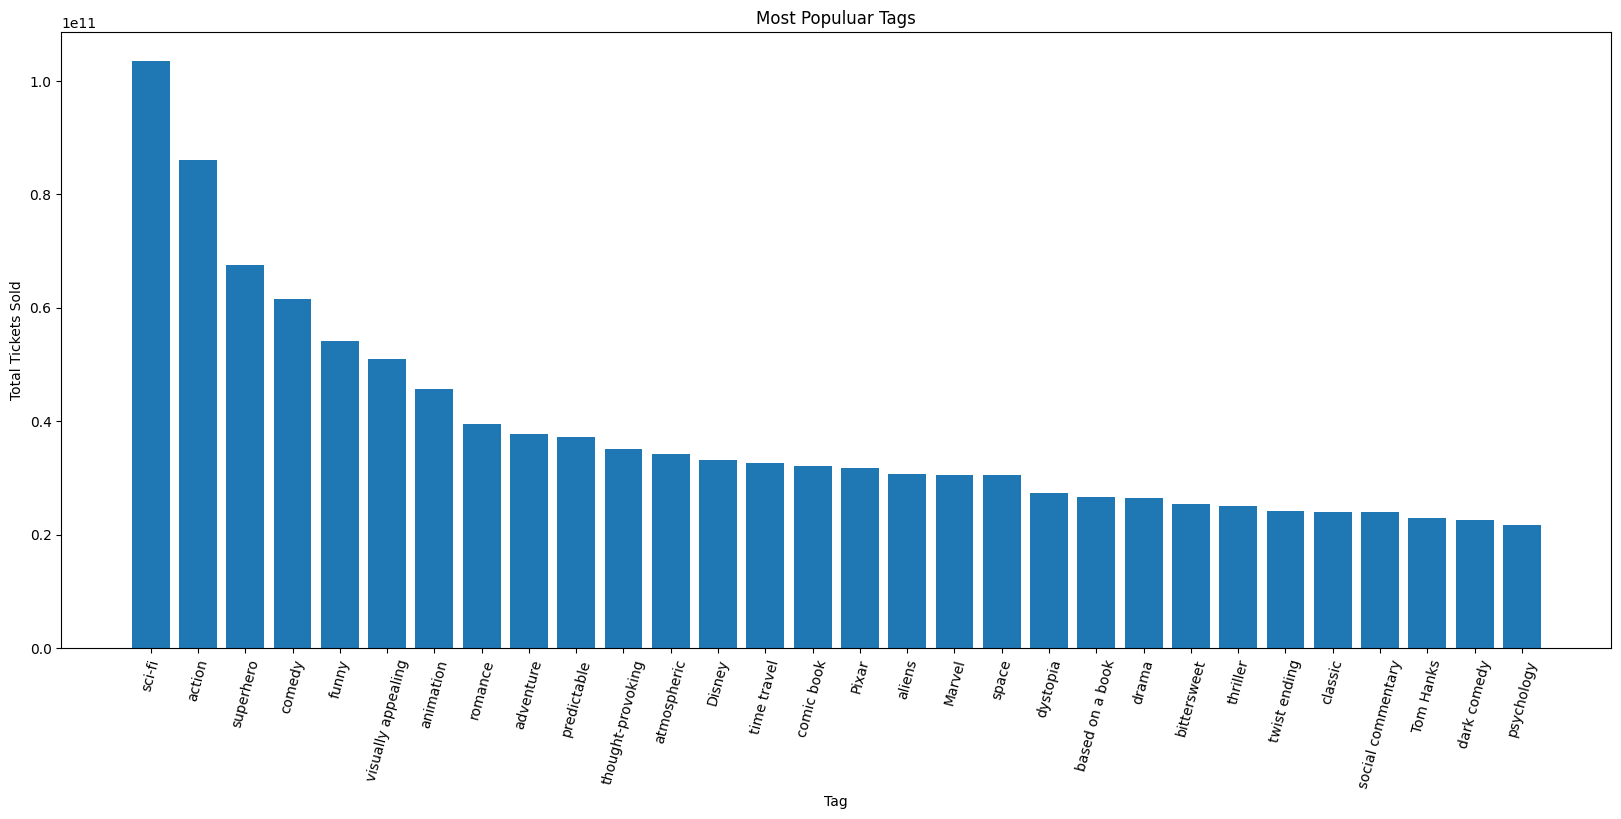

In [83]:
# We use a bar chart to show the magnitude of ticket sales for popular movie tags

fig = plt.figure(figsize=(20, 8))
plt.bar(tag_totals_tickets_sold_graph_df['tag'], tag_totals_tickets_sold_graph_df['sum_tickets_sold'])
plt.xlabel('Tag')
plt.ylabel('Total Tickets Sold')
plt.title('Most Populuar Tags')
plt.xticks(rotation=75)

plt.show()

So we can see a skew in the data. Popular movies will inevitably have more users voting (tagging or rating) and more movies released of a specific genre will have more opportunities to accumulate votes.

But what if we removed some of the top results for various genres and proper nouns (such as specific actors). Could we learn anything about the types of movies that users like to see? Are there certain qualities that these movies tend to have? Can the tags of movies show us what this might look like?

In [84]:
# Again, we sort by the sum of tickets sold, but this time we eliminate genres and proper nouns
tag_totals_df.sort_values(by=["sum_tickets_sold"], ascending=False, inplace=True)
# genres and proper nouns that showed up in original top 30
genresAndProperNouns = ["sci-fi",
"action",
"superhero",
"comedy",
"animation",
"romance",
"adventure",
"Disney",
"Pixar",
"Marvel",
"drama",
"thriller",
"classic",
"Tom Hanks",
"dark comedy",
"psychology",
"Leonardo DiCaprio",
"fantasy",
"historical",
"family",
"science fiction",
"suspense"
]

# We'll filter out the list of tags above to see a list of more unique tags that don't skew towards
# particular brands or actors
tag_totals_tickets_sold_unique_tags_graph_df = tag_totals_df[["tag", "sum_tickets_sold"]]
tag_totals_tickets_sold_unique_tags_graph_df = tag_totals_tickets_sold_unique_tags_graph_df[~tag_totals_tickets_sold_unique_tags_graph_df["tag"].isin(genresAndProperNouns)].head(30)
print(tag_totals_tickets_sold_unique_tags_graph_df)

                        tag  sum_tickets_sold
24055                 funny       54172897699
40023    visually appealing       50922233915
32798           predictable       37301179353
38400     thought-provoking       35084109844
16263           atmospheric       34139309952
38481           time travel       32719612059
19699            comic book       32096628877
15405                aliens       30751855458
36575                 space       30488682685
21941              dystopia       27346162432
16979       based on a book       26703236724
17494           bittersweet       25374578425
39206          twist ending       24212190251
36313     social commentary       23963534415
37617               surreal       21302950229
37348              stylized       20969067935
26575         inspirational       20712115063
15490     alternate reality       20570110039
39962              violence       20565071653
30026                 music       20359945442
19273        cinematography       

This paints a more interesting picture. For example, among the top 5 results are "visually appealing" and "atmospheric".

Users like to see movies that are visually appealing and atmospheric. This is useful information for a studio or production company to know: Movies shown in theaters have a unique value proposition. Movies on the big screen can amaze users with large screens and impressive sound systems, immersing the audience. Fans may not necessarily have these high-end audio-visual systems available at home.

Next we have "predictable". Interesting! Do movie-goers like predictable movies because they provide comfort? There are 10 Fast and the Furious Movies, 8 Mission Impossible Movies, 7 Transformers Movies, 25 James Bond Movies. Movies based on books (Think Harry Potter). You go because you know what you're getting.

Or is this instead a symptom that movies studios have been pushing are increasingly predictable? Does this show a lack of creativity? Marvel movies have been popular since Iron Man came out in 2008. They tend to be pretty formulaic. Bad guy gets something that puts the world in peril. Good guy fights bad guy but isn't strong enough. Leading up to the good guy powering up and defeating the big baddie either through creatively outsmarting him despite being weaker or through strength of will.

But people still go because they love sci-fi and the movies are funny! They love to be immersed in a different world.

Fear not, creativity is not dead. The next top tag is "thought-provoking". People may go to movies because they are funny, but they also want movies that challenge them to think. Inception, The Matrix. They also love a good twist or to be inspired.

And they'll see movies if other people say they are good. Like if the movie won an Oscar.

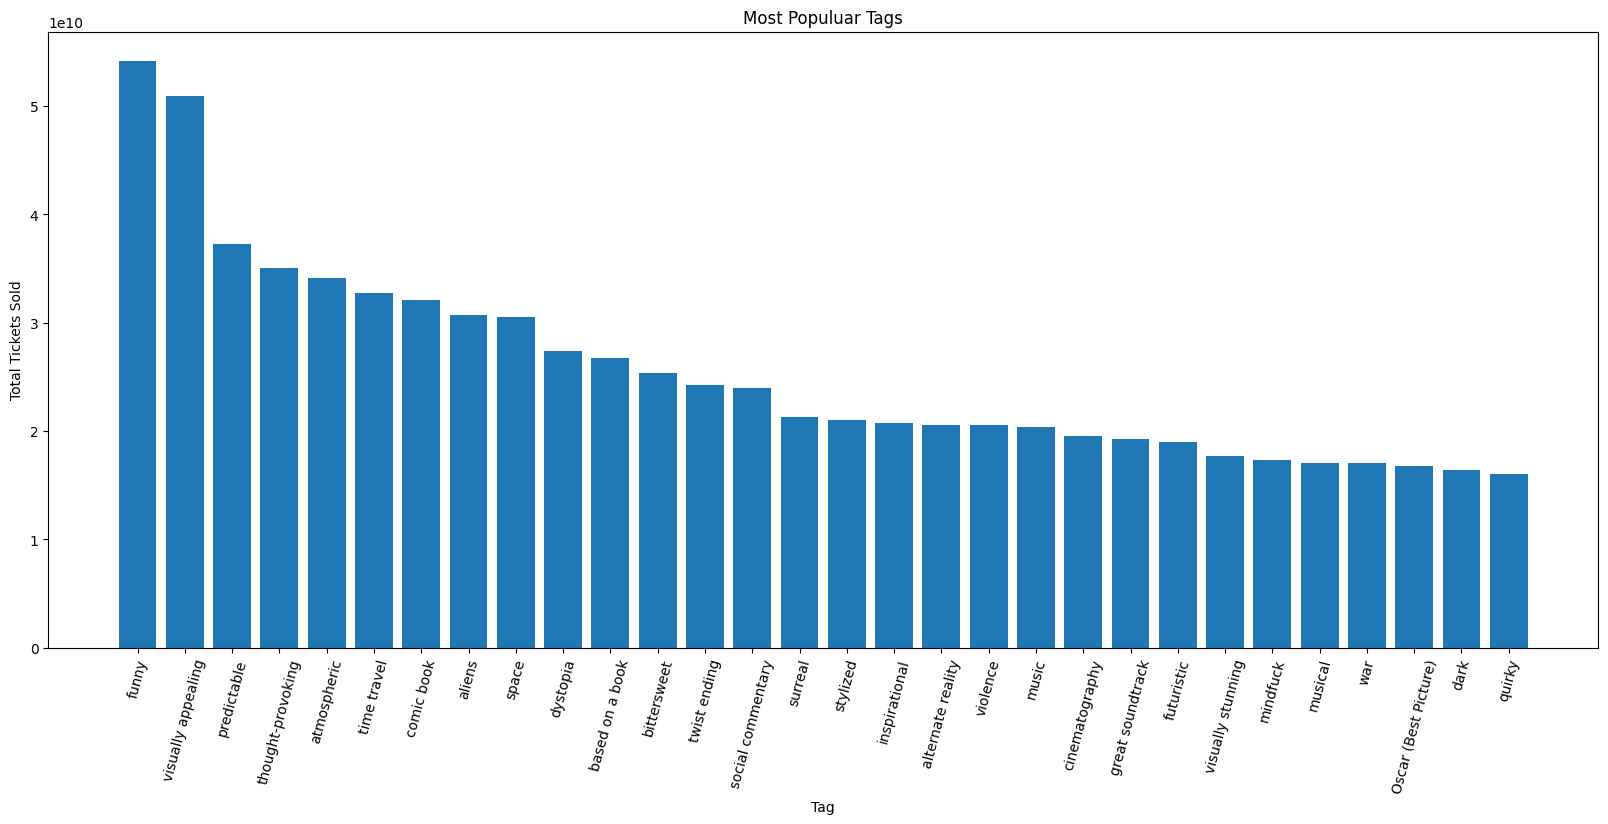

In [85]:
# We use a bar chart to show the magnitude of ticket sales for popular movie tags

fig = plt.figure(figsize=(20, 8))
plt.bar(tag_totals_tickets_sold_unique_tags_graph_df['tag'], tag_totals_tickets_sold_unique_tags_graph_df['sum_tickets_sold'])
plt.xlabel('Tag')
plt.ylabel('Total Tickets Sold')
plt.title('Most Populuar Tags')
plt.xticks(rotation=75)

plt.show()

We took a look at aggregate ticket sales, but do tags tell us anything about average ticket sales?

In [86]:
tag_totals_df.sort_values(by=["avg_tickets_sold"], ascending=False, inplace=True)
tag_avg_tickets_sold_graph_df = tag_totals_df[["tag", "avg_tickets_sold"]].head(30)
print(tag_avg_tickets_sold_graph_df)


                                   tag  avg_tickets_sold
2027                        Black Hero       76845177.00
8032                    Letitia Wright       76845177.00
33878                         relevant       76845177.00
40110                          wakanda       76845177.00
16259                        atmoshere       76845177.00
17514                       black cast       76845177.00
1756                     Bechdel Test+       76845177.00
21269                     director poc       76845177.00
4857                            Father       76845177.00
14331                             Woke       76845177.00
5200                          Futurist       76845177.00
17524                 black excellence       76845177.00
14311                     Winston Duke       76845177.00
12759         Strong Female Characters       76845177.00
39023                      tribal wars       76845177.00
26815                          iranium       76845177.00
28980                          

The top 30 results shows us that of the movies have seen most, we care more and more about diversity. The top few results are a proxy for the movie The Black Panther, a box office hit and one of the first movies to feature almost an entirely black cast. We also have the Bechdel Test as a tag, which is whether or not two or more female characters can have a scene where they do not discuss a man, and the Strong Female Characters tag. We also have movies lead by poc ("People of color").

Next, we thought it would be interesting to visualize tags for movies and actors using word clouds and bar charts.

## What is the "profile" of a movie or an actor/actress?

Can we take a quick glance at a visual to understand what a movie or actor/actress is about? Does a movie's popularity or actor/actresses success tend to overlap with the top tags for total ticket sales as we previously described?

People love Stephen Spielberg and his movies. His movie "Ready Player One" came out in 2018, which was based off a popular book "Ready Player One". Ready Player One (the book) received a 4.5 star on Amazon for over 147,000 ratings so the source content for the movie is irrefutably popular, at least for some people.

In [87]:
# Here we get the tag data for the movie Ready Player One

#print(ml_movies_tag_count_totals_df_filtered[ml_movies_tag_count_totals_df_filtered["title"] == "Ready Player One"].head(20))
ready_player_one_tags_df = ml_movies_tag_count_totals_df_filtered[ml_movies_tag_count_totals_df_filtered["title"] == "Ready Player One"].head(50)
print(ready_player_one_tags_df)

                   title   imdbId                         tag  \
958116  Ready Player One  1677720             virtual reality   
958124  Ready Player One  1677720                 video games   
958117  Ready Player One  1677720          Visually appealing   
958113  Ready Player One  1677720                 Pop culture   
958114  Ready Player One  1677720            Steven Spielberg   
958165  Ready Player One  1677720                 predictable   
958209  Ready Player One  1677720             Future dystopia   
958186  Ready Player One  1677720             80s video games   
958129  Ready Player One  1677720            movie references   
958119  Ready Player One  1677720                    dystopia   
958127  Ready Player One  1677720                  Easter Egg   
958121  Ready Player One  1677720             Good soundtrack   
958174  Ready Player One  1677720                      action   
958142  Ready Player One  1677720            evil corporation   
958146  Ready Player One 

Seems to have some of they key tags our overall top ticket sales movies shared:

It's visually appealing, predictable, based on a book.

It has has a good soundtrack.

It has action, romance, and adventure.

It's futuristic.

It's a sci-fi movie, one of our top tags!

So why did it get only a 7.4 on IMDB?

There's the tag - "bad writing". Not even nostalgia or a trip back to the 80's can save a movie that has bad writing.

(Just take a look at Ant-Man: Quantum Mania, which suffers the same problems despite popular tags, weighing in at a 6.3 on IMDB)

Studios and executives green-lighting these movies should always be thinking about the story.

Even popular source content, such as book based films, can backfire if the execution isn't good. Think Ghost in the Shell 2017.

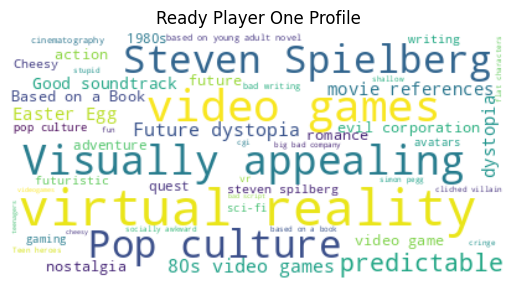

In [88]:
# We want a WordCloud to show the top tags for a high budget/box office film (Ready Player One)

tag_frequencies = dict(zip(ready_player_one_tags_df['tag'], ready_player_one_tags_df['unique_user_count_per_tag']))

wordcloud = WordCloud(background_color='white').generate_from_frequencies(tag_frequencies)

plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Ready Player One Profile')
plt.axis("off")
plt.show()

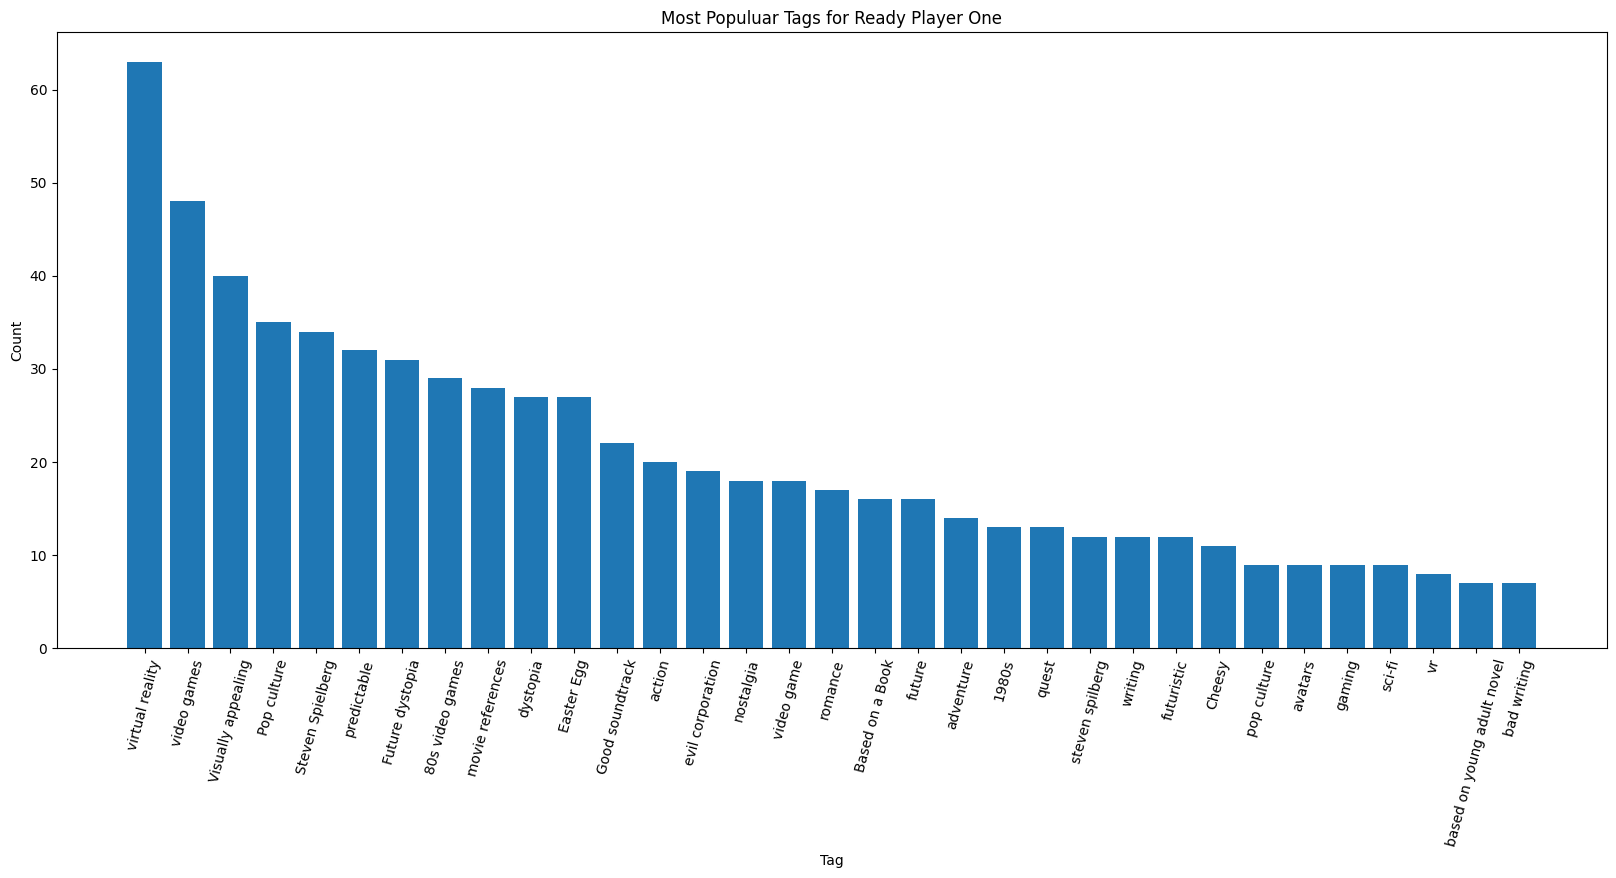

In [89]:
# We want a bar chart to show the most prevalent tagging for a high budget/box office film (Ready Player One)

ready_player_one_tags_df_top_20 = ready_player_one_tags_df.head(33)

fig = plt.figure(figsize=(20, 8))
plt.bar(ready_player_one_tags_df_top_20['tag'], ready_player_one_tags_df_top_20['unique_user_count_per_tag'])
plt.xlabel('Tag')
plt.ylabel('Count')
plt.title('Most Populuar Tags for Ready Player One')
plt.xticks(rotation=75)

plt.show()

This simply shows that on a relative basis, almost as many people tagged Ready Player One for bad writing as they tagged it to be a sci-fi movie.

## The Profiles of Actors and Actresses

For the purposes of this analysis, we'll look at some of the top paid actors to see if the tags associated with the movies they starred in seems to line up with the most popular tags of movies with top ticket sales.

In [90]:
# Get a list of actors and the total amount of domestic box office they've had
topActors_df.sort_values(by="domesticBoxOffice", ascending=False, inplace=True)
topActors_by_pay_df = topActors_df.copy()
topActors_by_pay_df["domesticBoxOffice"] = topActors_by_pay_df["domesticBoxOffice"].str.replace("$", "").str.replace(",", "").astype(int)
#print(topActors_df.head())
actor_boxoffice_df = topActors_by_pay_df.groupby("actorName")["domesticBoxOffice"].sum().reset_index()
actor_boxoffice_df.sort_values(by="domesticBoxOffice", ascending=False, inplace=True)
print(actor_boxoffice_df.head())

               actorName  domesticBoxOffice
20        Samuel Jackson        11560774402
21    Scarlett Johannson         5745491441
5            Chris Pratt         5546996612
24             Tom Hanks         5544829361
0   Benedict Cumberbatch         5421639994
/tmp/ipykernel_207/654166001.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  topActors_by_pay_df["domesticBoxOffice"] = topActors_by_pay_df["domesticBoxOffice"].str.replace("$", "").str.replace(",", "").astype(int)


In [91]:
# Get the top 10 actors by domesticBoxOffice
top_10_boxoffice_actors_df = actor_boxoffice_df.head(10)
print(top_10_boxoffice_actors_df)

               actorName  domesticBoxOffice
20        Samuel Jackson        11560774402
21    Scarlett Johannson         5745491441
5            Chris Pratt         5546996612
24             Tom Hanks         5544829361
0   Benedict Cumberbatch         5421639994
28           Zoe Saldana         5322813279
12         Harrison Ford         5249889116
1         Bradley Cooper         5234413700
23            Tom Cruise         5165314249
3            Chris Evans         5085959935


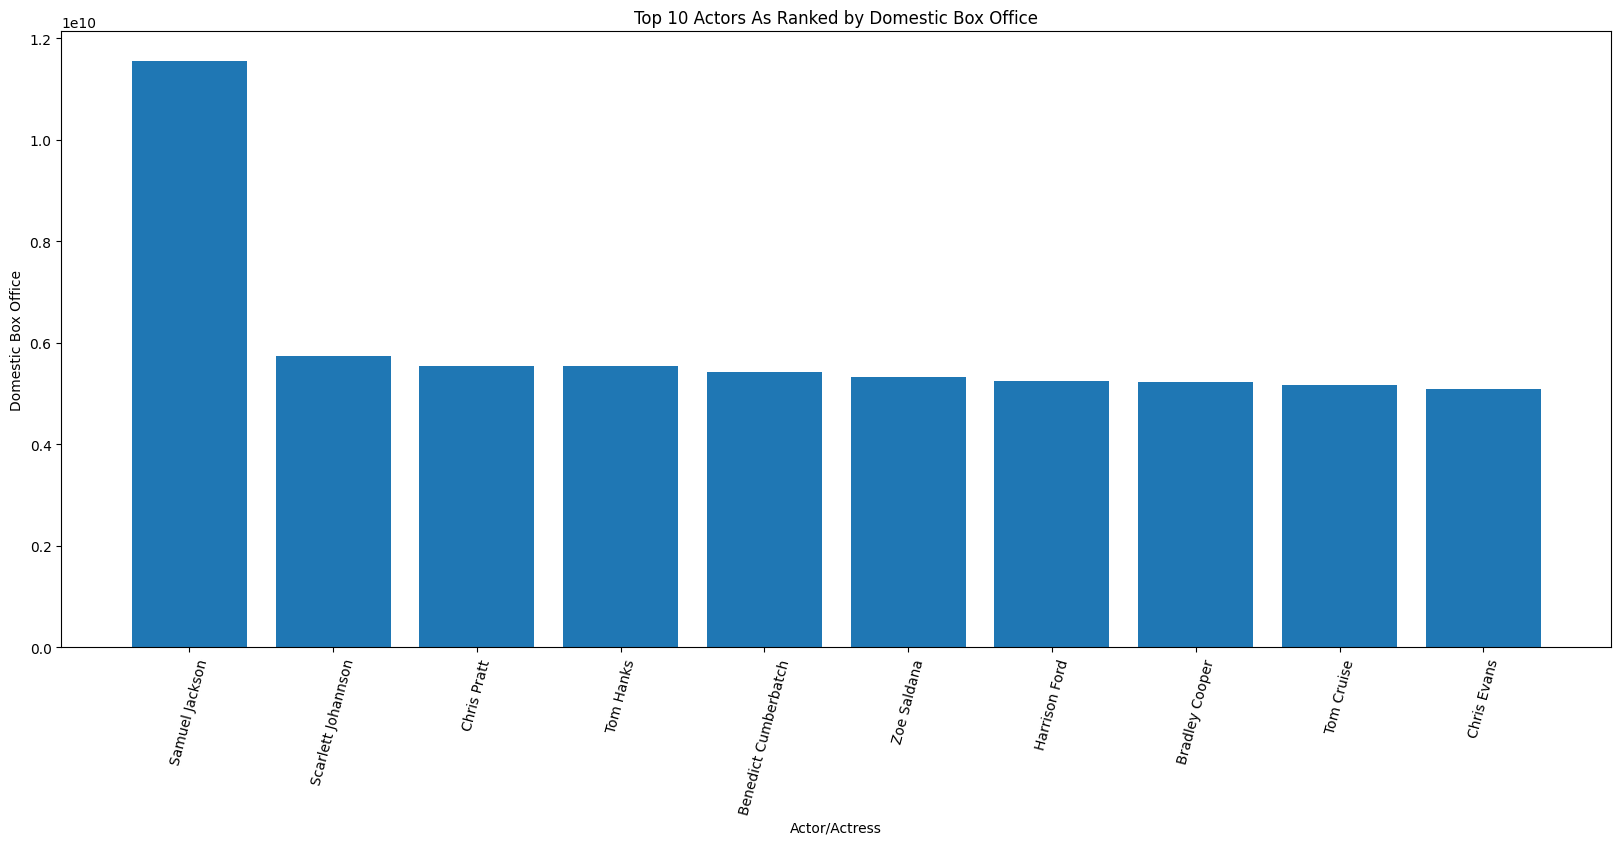

In [92]:
fig = plt.figure(figsize=(20, 8))
plt.bar(top_10_boxoffice_actors_df['actorName'], top_10_boxoffice_actors_df['domesticBoxOffice'])
plt.xlabel('Actor/Actress')
plt.ylabel('Domestic Box Office')
plt.title('Top 10 Actors As Ranked by Domestic Box Office')
plt.xticks(rotation=75)

plt.show()

I started this analysis with Harrison Ford because many people are familiar with his movies. But overall, we want to get the actors, their movies, and the associated tags into a dataframe that we can filter for the actors and actresses we'll be analyzing.

In [93]:
# We want to create a dataframe that has tags for movies that are associated with their actors
# We'll use this to create a profile for the actor where tags are representative of an actor's characteristics

actors_and_movie_tags_df = ml_movies_tag_count_totals_df.merge(people_and_imdb_movie_id_df, how='left', left_on="imdbId", right_on="imdbId")
#print(actors_and_movie_tags_df.head(20))
# is in topActors_df, sort by revenue
print(actors_and_movie_tags_df[actors_and_movie_tags_df["primaryName"] == "Harrison Ford"].head(20))


                                                   title  imdbId  \
0                     Star Wars: Episode IV - A New Hope   76759   
138                   Star Wars: Episode IV - A New Hope   76759   
442                   Star Wars: Episode IV - A New Hope   76759   
525                   Star Wars: Episode IV - A New Hope   76759   
608                   Star Wars: Episode IV - A New Hope   76759   
1015                  Star Wars: Episode IV - A New Hope   76759   
3233                  Star Wars: Episode IV - A New Hope   76759   
4074                  Star Wars: Episode IV - A New Hope   76759   
5102                  Star Wars: Episode IV - A New Hope   76759   
6135                  Star Wars: Episode IV - A New Hope   76759   
6385                  Star Wars: Episode IV - A New Hope   76759   
8962                  Star Wars: Episode IV - A New Hope   76759   
9045                  Star Wars: Episode IV - A New Hope   76759   
13376                 Star Wars: Episode IV - A 

In [94]:
# Example with the actor Harrison Ford
# Filter Harrison Ford's movie tags into a dataframe

harrison_ford_df = actors_and_movie_tags_df[actors_and_movie_tags_df["primaryName"] == "Harrison Ford"]
print(harrison_ford_df.head())

# harrison_ford_df_movies = harrison_ford_df[["title"]].drop_duplicates()
# print(harrison_ford_df_movies)
# harrison_ford_top_10_movies_df = harrison_ford_df.sort_values(by=['unique_user_count_per_tag'], ascending=False)
# harrison_ford_top_10_movies_df = harrison_ford_top_10_movies_df[["title", "imdbId"]].drop_duplicates()
# harrison_ford_top_10_movies_df = harrison_ford_top_10_movies_df.head(10)
# print(harrison_ford_top_10_movies_df)

                                  title  imdbId              tag  \
0    Star Wars: Episode IV - A New Hope   76759           sci-fi   
138  Star Wars: Episode IV - A New Hope   76759            space   
442  Star Wars: Episode IV - A New Hope   76759  space adventure   
525  Star Wars: Episode IV - A New Hope   76759  Science Fiction   
608  Star Wars: Episode IV - A New Hope   76759          classic   

     unique_user_count_per_tag  Unnamed: 0    primaryName imdbIdString  
0                       648.00       72.00  Harrison Ford    tt0076759  
138                     293.00       72.00  Harrison Ford    tt0076759  
442                     260.00       72.00  Harrison Ford    tt0076759  
525                     260.00       72.00  Harrison Ford    tt0076759  
608                     259.00       72.00  Harrison Ford    tt0076759  


Now that we have Harrison Ford's movies and associated tags, what characteristics rise to the top? What does his "acting profile" look like?

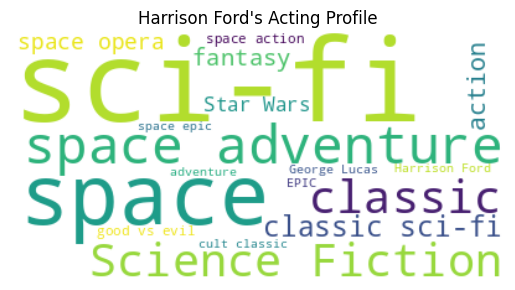

In [95]:
# We generate a WordCloud to create an acting profile (for Harrison Ford)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

harrison_ford_df = harrison_ford_df.sort_values(by=['unique_user_count_per_tag'], ascending=False)
harrison_ford_df = harrison_ford_df.head(20)

tag_frequencies = dict(zip(harrison_ford_df['tag'], harrison_ford_df['unique_user_count_per_tag']))

wordcloud = WordCloud(background_color='white').generate_from_frequencies(tag_frequencies)

plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Harrison Ford's Acting Profile")
plt.axis("off")
plt.show()

Looks like most call outs are for his iconic role as Han Solo in the Star Wars franchise by George Lucas

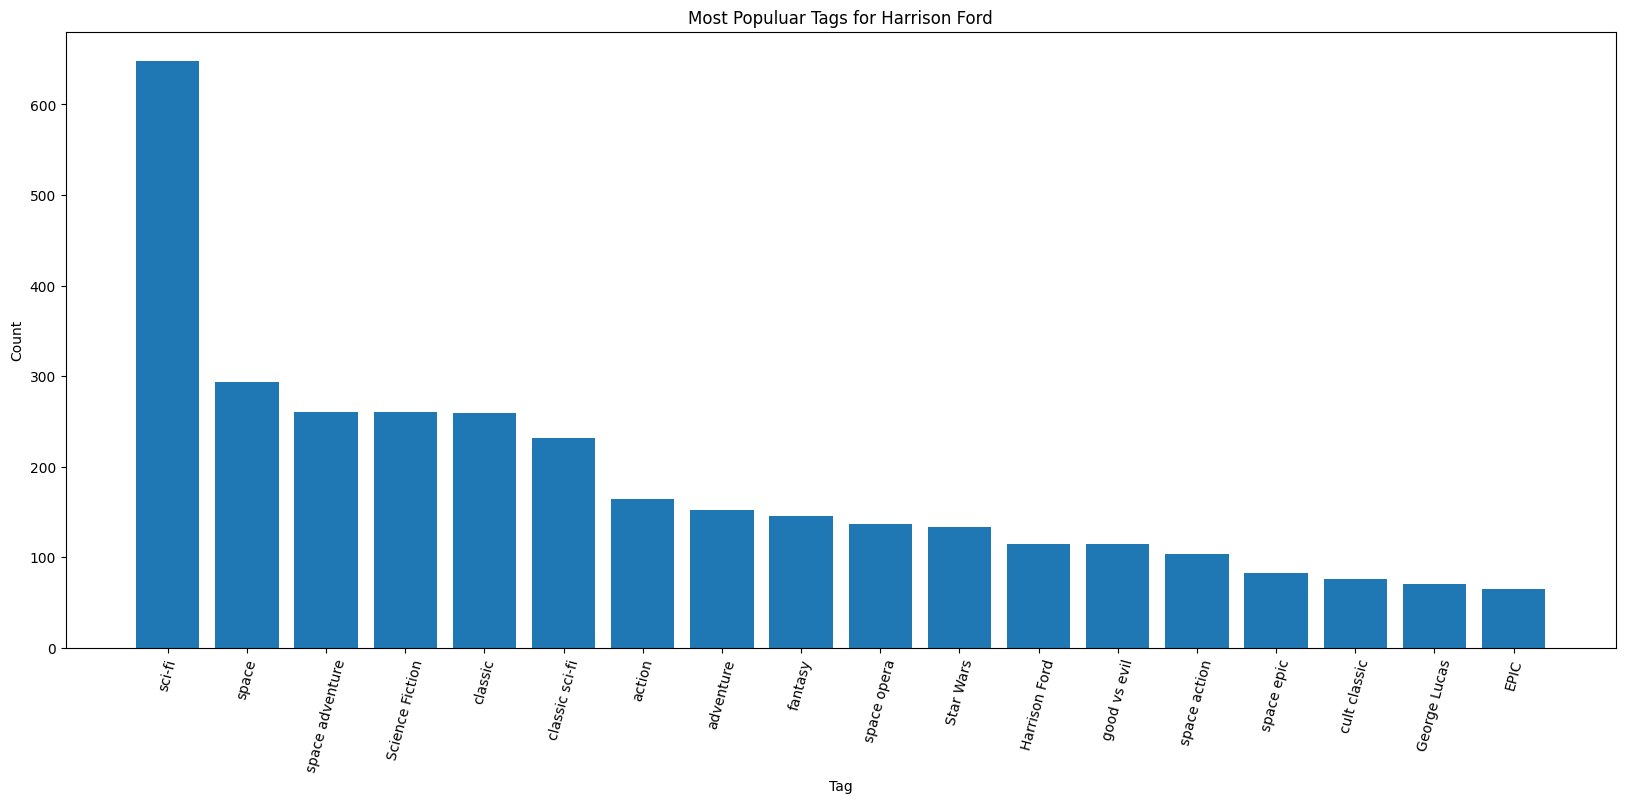

In [96]:
# We show the most popular tags of movies with which an actor is associated (Harrison Ford)

harrison_ford_df = harrison_ford_df.head(20)

fig = plt.figure(figsize=(20, 8))
plt.bar(harrison_ford_df['tag'], harrison_ford_df['unique_user_count_per_tag'])
plt.xlabel('Tag')
plt.ylabel('Count')
plt.title('Most Populuar Tags for Harrison Ford')
plt.xticks(rotation=75)

plt.show()

Our data above showed that Harrison Ford was top 7 domestic box office. His tags seem to align with the top ticket sales tags, the highest again being sci-fi.

However, people also consider Harrison Ford to be "classic". He has had a long career, from Indiana Jones to Star Wars to Blade Runner. Classic movies. He's also in a lot of movies as the "good guy" in a good vs. evil epic.

Next we have Samuel L. Jackson, the number 1 domestic box office actor.

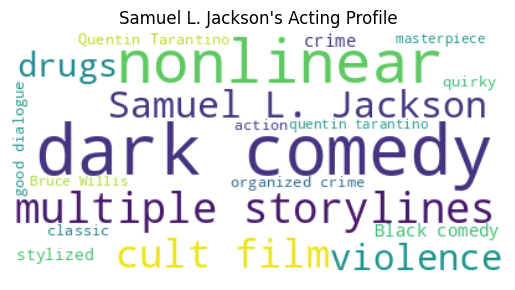

In [97]:

samuel_jackson_df = actors_and_movie_tags_df[actors_and_movie_tags_df["primaryName"] == "Samuel L. Jackson"]
samuel_jackson_df = samuel_jackson_df.sort_values(by=['unique_user_count_per_tag'], ascending=False)
samuel_jackson_df = samuel_jackson_df.head(20)

tag_frequencies = dict(zip(samuel_jackson_df['tag'], samuel_jackson_df['unique_user_count_per_tag']))

wordcloud = WordCloud(background_color='white').generate_from_frequencies(tag_frequencies)

plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Samuel L. Jackson's Acting Profile")
plt.axis("off")
plt.show()

Samuel L. Jackson has been in many different types of films. His movies are funny (with a little darkness) and violent. And he tends to have a cult following. These tags are pretty different from the tags for the overall top ticket sales movies.

So what makes him successful?

Well, for starters, he's been in over 150 movies. He's got multiple story lines. And he's funny. This gives him a cult following and makes his acting style unique and recognizable so all the MF-ing fans want to see his MF-ing movies.

Even when they're on a MF-ing plane.

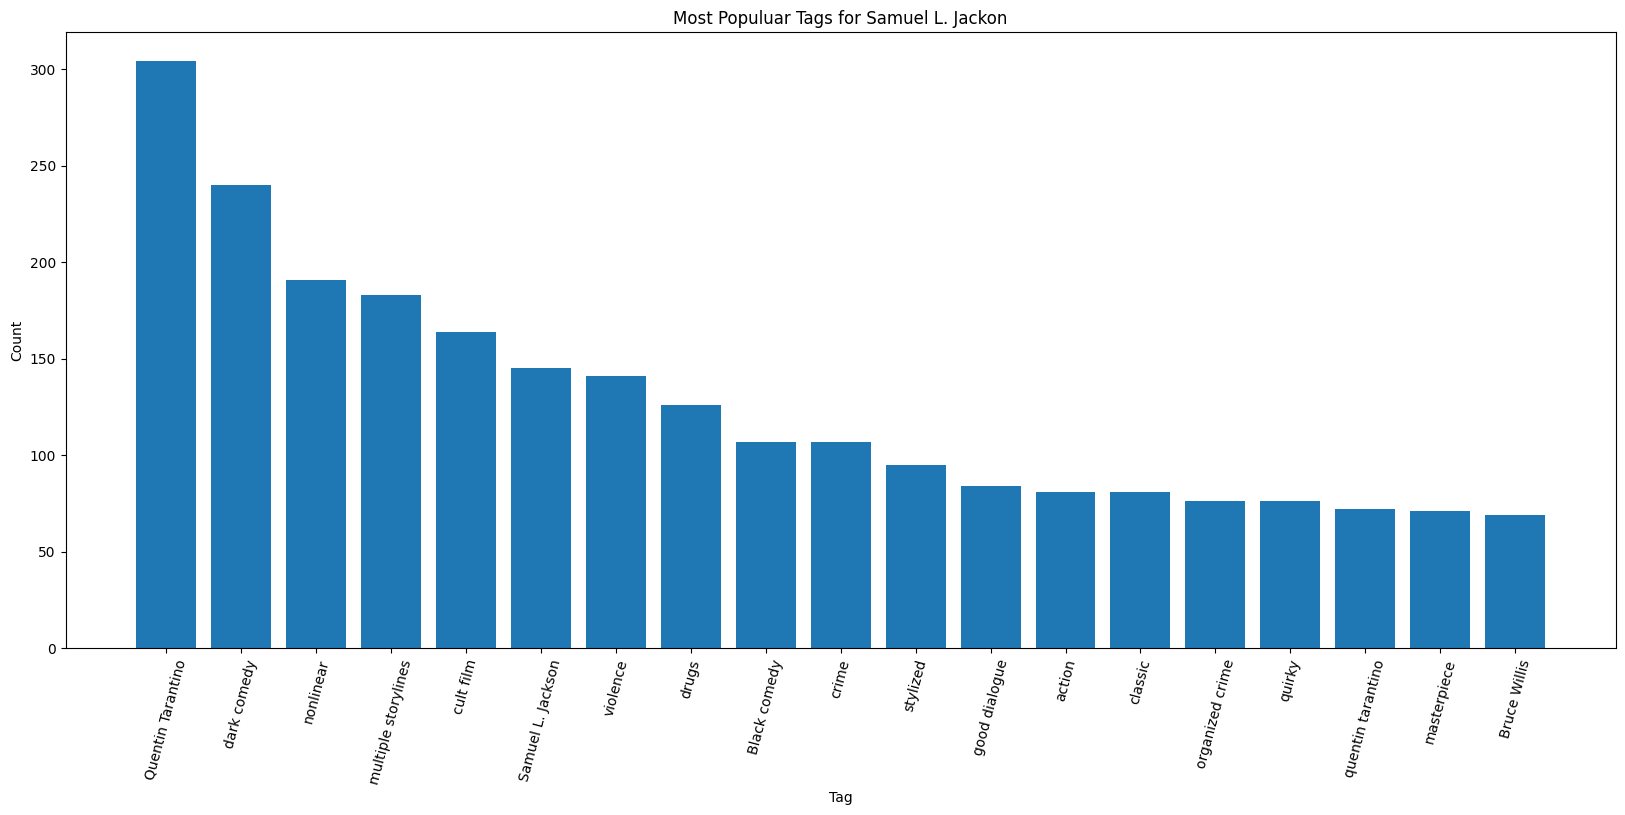

In [98]:
samuel_jackson_df = samuel_jackson_df.head(20)

fig = plt.figure(figsize=(20, 8))
plt.bar(samuel_jackson_df['tag'], samuel_jackson_df['unique_user_count_per_tag'])
plt.xlabel('Tag')
plt.ylabel('Count')
plt.title('Most Populuar Tags for Samuel L. Jackon')
plt.xticks(rotation=75)

plt.show()

Scarlett Johansson was the second top domestic box office actress. What can her acting profile show us?

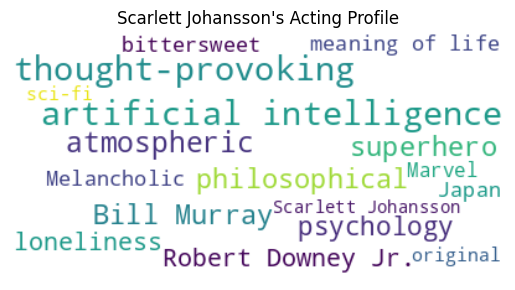

In [99]:
# Get the tag data for Scarlett Johansson

scarlett_johansson_df = actors_and_movie_tags_df[actors_and_movie_tags_df["primaryName"] == "Scarlett Johansson"]
scarlett_johansson_df = scarlett_johansson_df.sort_values(by=['unique_user_count_per_tag'], ascending=False)
scarlett_johansson_df = scarlett_johansson_df.head(20)

tag_frequencies = dict(zip(scarlett_johansson_df['tag'], scarlett_johansson_df['unique_user_count_per_tag']))

wordcloud = WordCloud(background_color='white').generate_from_frequencies(tag_frequencies)

plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Scarlett Johansson's Acting Profile")
plt.axis("off")
plt.show()

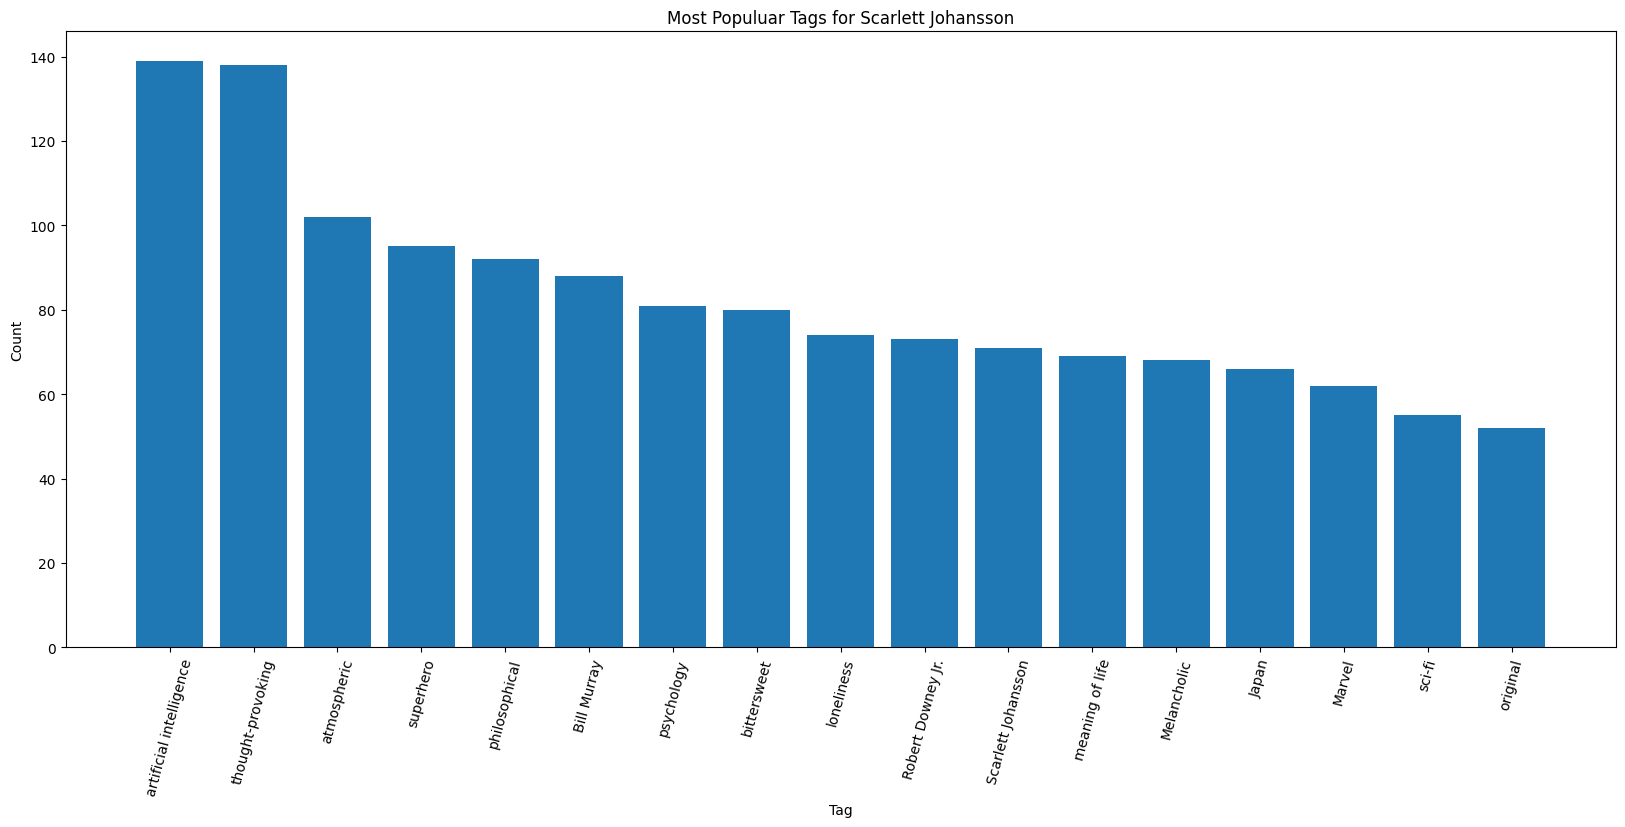

In [100]:
scarlett_johansson_df = scarlett_johansson_df.head(20)

fig = plt.figure(figsize=(20, 8))
plt.bar(scarlett_johansson_df['tag'], scarlett_johansson_df['unique_user_count_per_tag'])
plt.xlabel('Tag')
plt.ylabel('Count')
plt.title('Most Populuar Tags for Scarlett Johansson')
plt.xticks(rotation=75)

plt.show()

Scarlett Johansson's profile takes us back to our original overall ticket sales tags analysis.

It shows us that we as an audience do enjoy thought-provoking and philosophical movies that make us think. These types of movies can do very well at the box office, which can be helpful for an actor or actress' career. We appreciate and go to see movies that make us contemplate the meaning of life. Movies that feel original. Because these elements are popular (combined of course with Scarlett's popular superhero movies like The Avengers, it's no wonder Scarlett scores the top 2 domestic box office. Her movies align with the characteristics of top selling movies. They make us think.

Chris Pratt's profile can be summarized as adventurous, clever, funny, and fun. This takes us back to his TV days in Parks and Recreation, so his casting is often in roles that take advantage of his charisma. Over time, he has taken on larger lead roles (mostly action and sci-fi) for movies such as Guardians of the Galaxy.

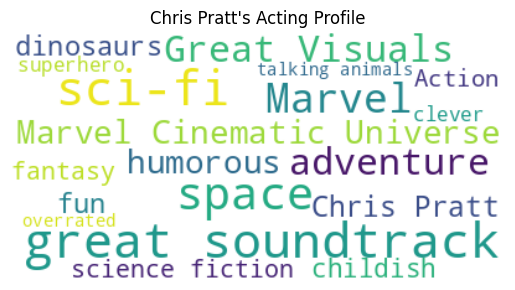

In [101]:

chris_pratt_df = actors_and_movie_tags_df[actors_and_movie_tags_df["primaryName"] == "Chris Pratt"]
chris_pratt_df = chris_pratt_df.sort_values(by=['unique_user_count_per_tag'], ascending=False)
chris_pratt_df = chris_pratt_df.head(20)

tag_frequencies = dict(zip(chris_pratt_df['tag'], chris_pratt_df['unique_user_count_per_tag']))

wordcloud = WordCloud(background_color='white').generate_from_frequencies(tag_frequencies)

plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Chris Pratt's Acting Profile")
plt.axis("off")
plt.show()

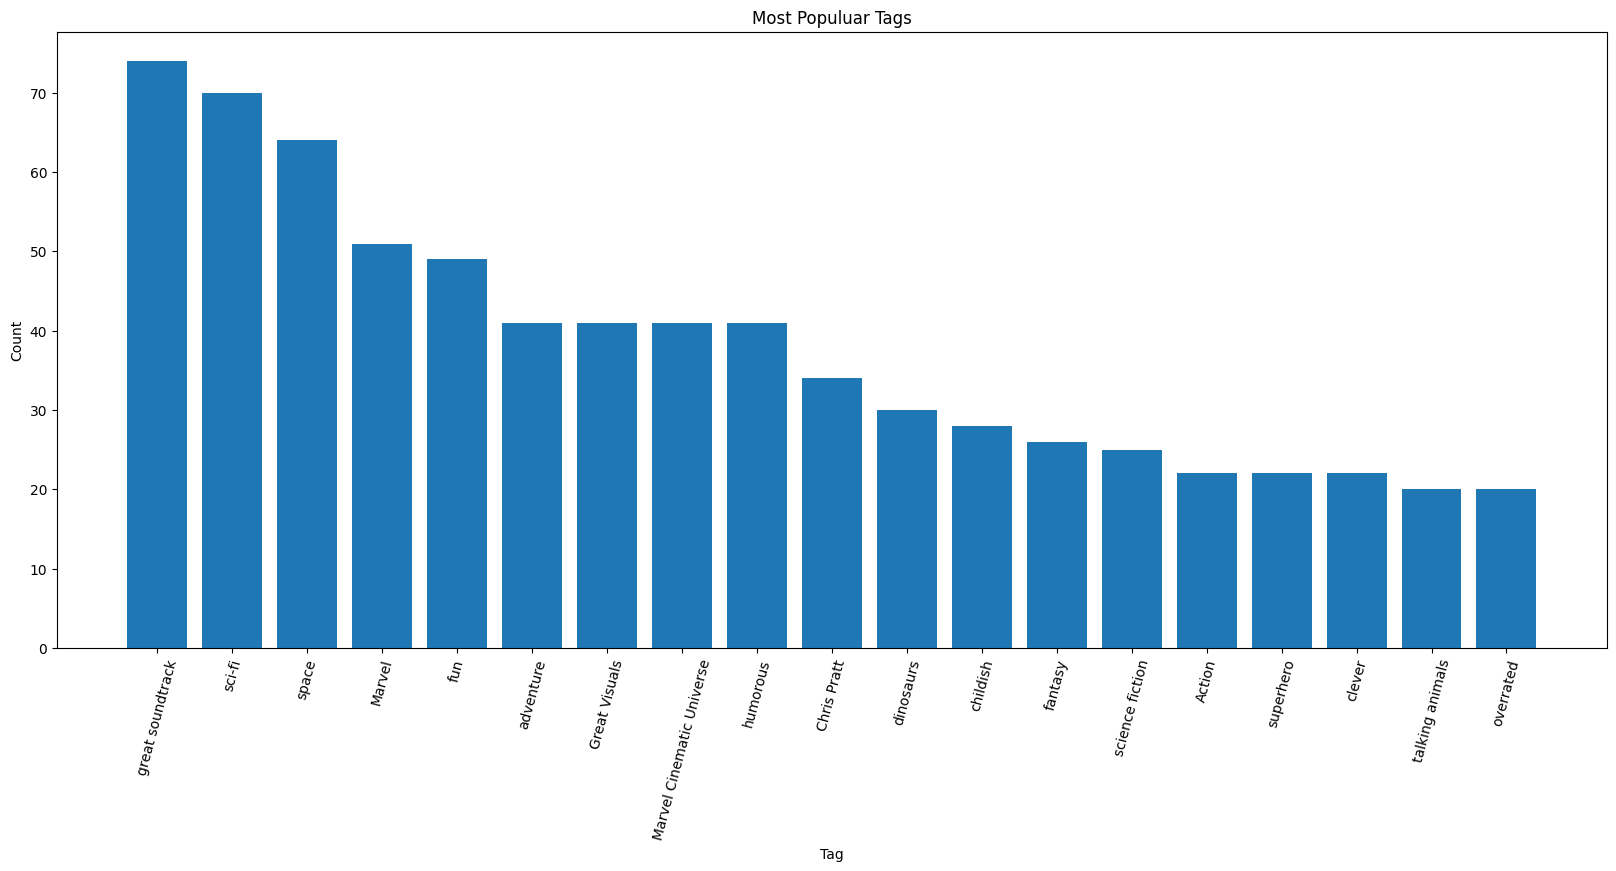

In [102]:
chris_pratt_df = chris_pratt_df.head(20)

fig = plt.figure(figsize=(20, 8))
plt.bar(chris_pratt_df['tag'], chris_pratt_df['unique_user_count_per_tag'])
plt.xlabel('Tag')
plt.ylabel('Count')
plt.title('Most Populuar Tags')
plt.xticks(rotation=75)

plt.show()

I thought it would be interesting to take a look at Zoe Saldana's acting profile because she ranks top 6 by domestic box office and has overlap with Chris Pratt on the popular box office hit The Guardians of The Galaxy and related Marvel Cinematic Universe films. I wanted to see if the results would skew towards the movies they starred in or if we'd be able to see more qualities about Zoe Saldana from the user generated tags.

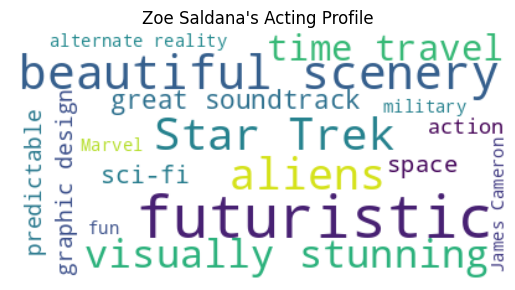

In [103]:


zoe_saldana_df = actors_and_movie_tags_df[actors_and_movie_tags_df["primaryName"] == "Zoe Saldana"]
zoe_saldana_df = zoe_saldana_df.sort_values(by=['unique_user_count_per_tag'], ascending=False)
zoe_saldana_df = zoe_saldana_df.head(20)

tag_frequencies = dict(zip(zoe_saldana_df['tag'], zoe_saldana_df['unique_user_count_per_tag']))

wordcloud = WordCloud(background_color='white').generate_from_frequencies(tag_frequencies)

plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Zoe Saldana's Acting Profile")
plt.axis("off")
plt.show()




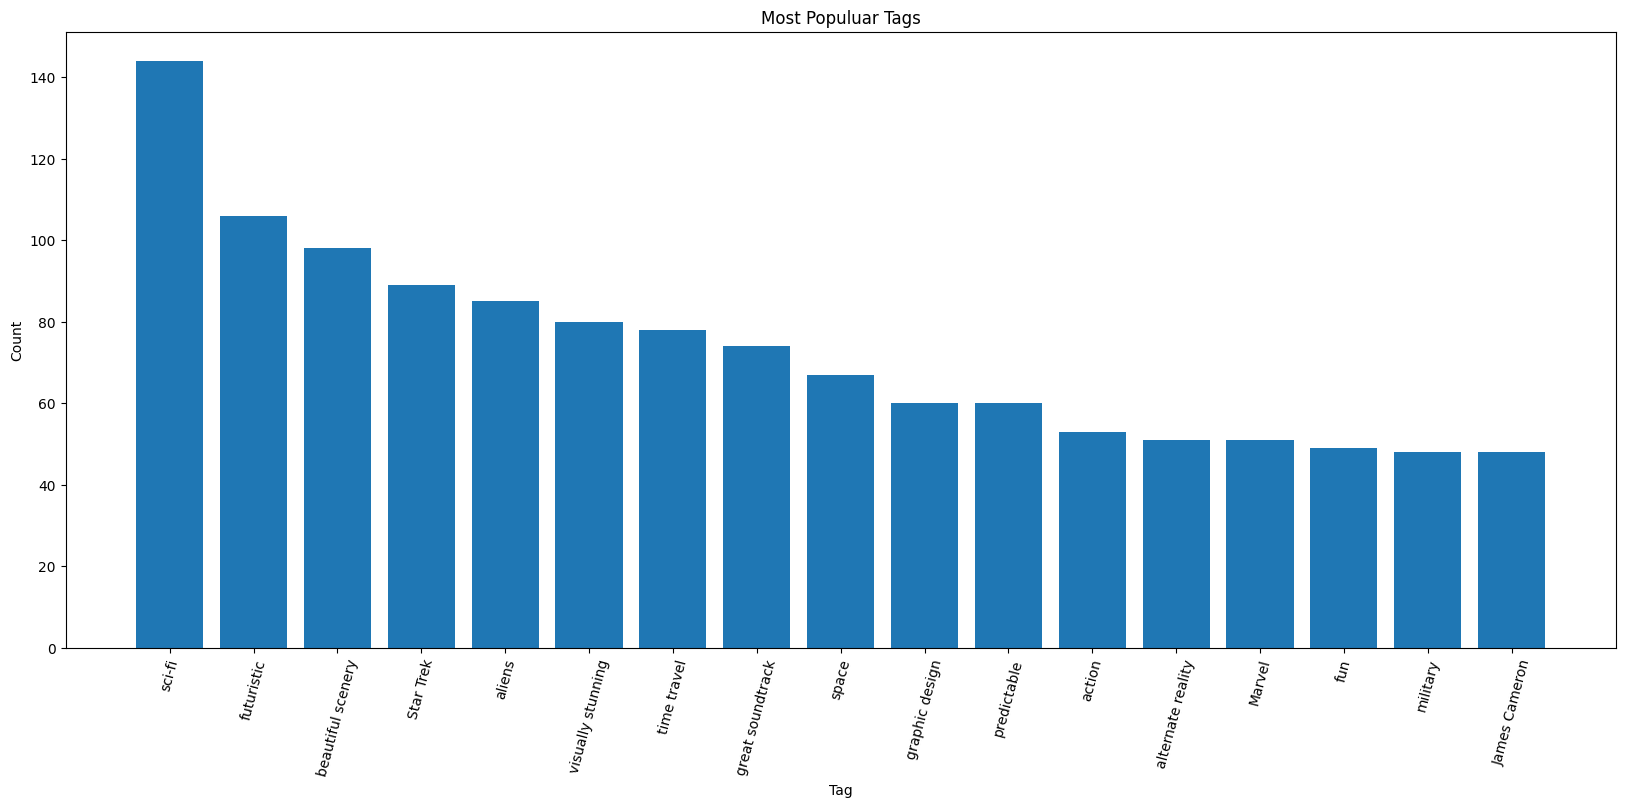

In [104]:
zoe_saldana_df = zoe_saldana_df.head(20)

fig = plt.figure(figsize=(20, 8))
plt.bar(zoe_saldana_df['tag'], zoe_saldana_df['unique_user_count_per_tag'])
plt.xlabel('Tag')
plt.ylabel('Count')
plt.title('Most Populuar Tags')
plt.xticks(rotation=75)

plt.show()

Zoe Saldana has in fact starred in other sci-fi films besides the Marvel Films, such as the 2009 Star Trek movies reboot, and we see these characteristics shape her actress profile. She has been in many large "need to see in theaters", visually appealing/visually stunning movies, like Avatar, Star Trek, Guardians of the Galaxy. We can also see how she is often cast as a fighter, sometimes in a "military" context.

## Acting Profiles Are Useful

Through this analysis, we see how automating the process above into a tool could help actors and actresses discover what the audience likes about them. Since the tags come from users, studios/executives could select certain people known for certain genres or characterizations to increase the ticket sales for their movies. For example, casting Harrison Ford in good vs. evil storylines as the "good guy" or Samuel L. Jackson in violent movies as the comedic relief could boost revenue. Or casting Scarlett Johansson in a movie that is thought provoking could be a good choice.

Combining these tags with a similar regression analysis as in prior sections could be applied not only to ratings, but also potentially to ticket sales, so producers should care to review this type of data before casting  an actor or actress for a new movie.

# Overall Summary and Learnings

We've seen from the data above that a variety of factors may affect the popularity or box office success of a movie. Actors have long careers, spanning decades and winning different awards. They may become popular and known for certain genres, characterizations, or franchises. Industry analysts could develop models such as those we used above for predictive analytics to forecast revenue from box office ticket sales, estimate appropriate salaries for talent, or anticipate whether a movie will be rated highly or received positively by the audience.

## Challenges and Obstacles

Many of our challenges were around getting the data from different data sources and processing them to be able to be combined for a variety of different analyses. The datasets we used were quite large and initially we weren't able to load some of them without crashing our machine due to limitations on RAM. We ultimately decided to chunk our data to reduce RAM overload and overwrite the results after multiple filtering processing back into a CSV to reduce future computations. 

After getting the data into a queryable form, we also discovered that some common fields were not exactly matching or formatted consistently across our datasets and we spent a long time trying to figure out how to reconcile these. For example, we tried various fuzzy match solutions from custom functions to Google sheets add-ons and discovered that processing these was computationally expensive and time consuming. To problem solve for this, we ended up using a variety of heuristics, such as regex string matching for a substring of initial characters.

Manually scraping data led to some challenges as certain information wasn't so nicely packaged for us to retrieve in one go. Actor's box office revenues had to be manually scraped by page and then compiled into a folder for us to programmatically filter each actor's profile 

# Appendix

Below are some code blocks and resources we used during the course of our final project which are no longer needed now that the data has been imported and cleaned up to be usable.

We needed to try various types of fuzzy string matching. This particular implementation was too computationally expensive, so we decided not to use it.

In [105]:
# # !pip install fuzzywuzzy
# # !pip install python-Levenshtein
# # from fuzzywuzzy import fuzz
# # from fuzzywuzzy import process

# # Treat IMDB dataset titles and names as the source of truth

# # print(imdb_title_basic_df.head())

# def get_matching_imdb_field(inputField, dataset, column, threshold=80):
#     result = process.extractOne(inputField, dataset[column].tolist(), score_cutoff=threshold)
#     if result is not None and len(result) == 2:
#         best_match, score = result
#         return best_match
#     else:
#         return None

# print(get_matching_imdb_field('star wars the empire strikes back',imdb_title_basic_df , 'primaryTitle'))
# print(get_matching_imdb_field('samuel jackson', imdb_name_basic_df, 'primaryName'))


In [106]:
# 
# # Standardize the titles with the imdb database
# ml_movies_and_tags_and_links_df["title"].apply(lambda x: get_matching_imdb_field(x, imdb_title_basic_df, 'primaryTitle'))

Here are some examples of using fuzzy match to get the canonical actor names to be used as filters for acting profiles

In [107]:

#print(match_name('star wars the empire strikes back',imdb_title_basic_df , 'primaryTitle'))
#print(match_name('samuel jackson', imdb_name_basic_df, 'primaryName'))
#print(match_name('Scarlett Johannson', imdb_name_basic_df, 'primaryName'))
#print(match_name('Chris Pratt', imdb_name_basic_df, 'primaryName'))
# print(match_name('Zoe Saldana', imdb_name_basic_df, 'primaryName'))



While we would have liked to explore how ratings and tags are related, we instead chose to focus on ticket sales and top ranked actors and actresses due to time constraints.

Links to resources:


In [108]:
# Move to Appendix

# !pip install fuzzywuzzy
# !pip install python-Levenshtein
# from fuzzywuzzy import fuzz
# from fuzzywuzzy import process
def match_name(movie_name, dataset, movie_name_column, threshold=80):
    match = process.extractOne(movie_name, dataset[movie_name_column], score_cutoff=threshold)
    if match:
        matched_movie, _, matched_index = match
        matched_row = dataset[dataset[movie_name_column] == matched_movie]
        return matched_row
    return pd.DataFrame()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2f5fb65f-e377-42a7-b17e-23e05a3eccd3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>